In [31]:
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
import numpy                   as np
from itertools                 import count
from sklearn.metrics.pairwise  import euclidean_distances
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.metrics           import accuracy_score, confusion_matrix
from sklearn.naive_bayes       import GaussianNB
from sklearn.preprocessing     import StandardScaler, Normalizer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error
from scipy.signal              import savgol_filter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [32]:
data = pd.read_csv('glucose.csv', dayfirst=True, parse_dates =["Date"], index_col ="Date")
data

,Insulin,Glucose
Date,,
1991-03-01 08:00:00,7.0,281
1991-03-01 12:00:00,NaN,209
1991-03-01 18:00:00,10.0,116
1991-03-01 22:00:00,NaN,321
1991-03-02 08:00:00,7.0,304
...,...,...
1991-07-26 22:00:00,NaN,111
1991-07-27 08:00:00,15.0,201
1991-07-27 12:00:00,8.0,121


In [33]:
def Missing_Values(data):
    variable_name = []
    total_value = []
    total_missing_value = []
    missing_value_rate = []
    unique_value_list = []
    total_unique_value = []
    data_type = []
    
    for col in data.columns:
        variable_name.append(col)
        data_type.append(data[col].dtype)
        total_value.append(data[col].shape[0])
        total_missing_value.append(data[col].isnull().sum())
        missing_value_rate.append(round(data[col].isnull().sum()/data[col].shape[0],4))
        unique_value_list.append(data[col].unique())
        total_unique_value.append(len(data[col].unique()))
        
    missing_data=pd.DataFrame({"Variable":variable_name,\
                               "#_Total_Value":total_value,\
                               "#_Total_Missing_Value":total_missing_value,\
                               "%_Missing_Value_Rate":missing_value_rate,\
                               "Data_Type":data_type,"Unique_Value":unique_value_list,\
                               "Total_Unique_Value":total_unique_value
                              })
    
    missing_data = missing_data.set_index("Variable")
    return missing_data.sort_values("#_Total_Missing_Value",ascending=False)

In [34]:
data_info = Missing_Values(data)
data_info

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
Insulin,596,86,0.1443,float64,"[7.0, nan, 10.0, 3.0, 0.0, 12.0, 8.0, 11.0, 13...",17
Glucose,596,0,0.0000,int64,"[281, 209, 116, 321, 304, 266, 105, 292, 69, 4...",163


In [35]:
data = data.dropna()

In [36]:
data_info = Missing_Values(data)
data_info

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
Insulin,510,0,0.0,float64,"[7.0, 10.0, 3.0, 0.0, 12.0, 8.0, 11.0, 13.0, 5...",16
Glucose,510,0,0.0,int64,"[281, 116, 304, 105, 292, 69, 421, 360, 121, 3...",156


In [37]:
data.describe()

,Insulin,Glucose
count,510.000000,510.000000
mean,8.058824,160.550980
std,3.444832,66.079314
min,0.000000,33.000000
25%,7.000000,110.000000
50%,8.000000,160.000000
75%,10.000000,196.000000
max,16.000000,421.000000


In [38]:
# Granularity: atomic (daily)
daily_data = data
# Granularity: weekly
weekly_data = data.resample('W').mean()
# Granularity: monthly
monthly_data = data.resample('M').mean()

In [39]:
def boxplot(data, filename):
    """"""

    #fig, ax = plt.subplots()
    sns.boxplot(data=data)
    plt.savefig('plots/'+filename + ".png")
    plt.close()

In [40]:
boxplot(daily_data, 'boxplot_drought_forecasting_dailySeparated')
boxplot(weekly_data, 'boxplot_drought_forecasting_weeklySeparated')
boxplot(monthly_data, 'boxplot_drought_forecasting_monthlySeparated')

In [41]:
def histograms(data, filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(24, 14))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].hist(data[col])
        ax[pos_i][pos_j].set_title(col)
        ax[pos_i][pos_j].legend()
        
    plt.savefig('plots/' + filename + '.png')
    plt.close()

In [42]:
histograms(daily_data, 'hist_drought_forecasting_dailySeparated', (2, 4))
histograms(weekly_data, 'hist_drought_forecasting_weeklySeparated', (2, 4))
histograms(monthly_data, 'hist_drought_forecasting_monthlySeparated', (2, 4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [43]:
def plot_stationarity(data, filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(24, 14))
    
    for position in range(len(data.columns)):
        col = data.columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].plot(data[col])
        ax[pos_i][pos_j].set_title(col)
        ax[pos_i][pos_j].legend()
        
    plt.savefig('plots/' + filename + '.png')
    plt.close()

In [44]:
plot_stationarity(daily_data, 'stationarity_drought_forecantig_dailySeparated', (2, 4))
plot_stationarity(weekly_data, 'stationarity_drought_forecantig_weeklySeparated', (2, 4))
plot_stationarity(monthly_data, 'stationarity_drought_forecantig_monthlySeparated', (2, 4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [45]:
def temporal_data_split_forPersistence(data, train_size=0.80):

    data = pd.DataFrame(data)
    lim = round(len(data)*train_size)

    tmp_data_x = data.shift(1)
    X_train = tmp_data_x.iloc[1:lim]
    X_test = tmp_data_x.iloc[lim:]
    Y_train = data.iloc[1:lim]
    Y_test = data.iloc[lim:]
    return X_train, X_test, Y_train, Y_test

In [46]:
# persistence model
def model_persistence(x):
    return x

In [47]:
def persistence_model(X_test, Y_test):

   predictions = []
   for x in np.array(X_test):
      yhat = model_persistence(x)
      predictions.append(yhat)
      
   rmse = (mean_squared_error(Y_test, predictions))**(1/2)
   res = [Y_test, pd.DataFrame(predictions, index=X_test.index)]
   return res, rmse

In [48]:
def plot_persistence(data, columns,  filename, dimension):
    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    
    for position in range(len(columns)):
        col = columns[position]

        pos_i = position//j
        pos_j = position%j

        ax[pos_i][pos_j].plot(data[position][0], color = "red")
        ax[pos_i][pos_j].plot(data[position][1], color = "green")
        plt.legend(col)
        plt.xticks(rotation=45)

    plt.savefig('plots/' + filename + '.png')

In [49]:
data_daily_persistenceRes = []
data_weekly_persistenceRes = []
data_monthly_persistenceRes = []

stats_ps = pd.DataFrame(columns=['var', 'rmse - daily', 'rmse - weekly', 'rmse - monthly'])

c = 0
for col in daily_data.columns:

    X_train_d, X_test_d, Y_train_d, Y_test_d = temporal_data_split_forPersistence(daily_data[col])
    X_train_w, X_test_w, Y_train_w, Y_test_w = temporal_data_split_forPersistence(weekly_data[col])
    X_train_m, X_test_m, Y_train_m, Y_test_m = temporal_data_split_forPersistence(monthly_data[col])

    res_ps_daily, rmse_ps_daily = persistence_model(X_test_d, Y_test_d)
    res_ps_weekly, rmse_ps_weekly = persistence_model(X_test_w, Y_test_w)
    res_ps_monthly, rmse_ps_monthly = persistence_model(X_test_m, Y_test_m)

    data_daily_persistenceRes.append(res_ps_daily)
    data_weekly_persistenceRes.append(res_ps_weekly)
    data_monthly_persistenceRes.append(res_ps_monthly)

    stats_ps[c] = [col, rmse_ps_daily, rmse_ps_weekly, rmse_ps_monthly]
    
    c+=1

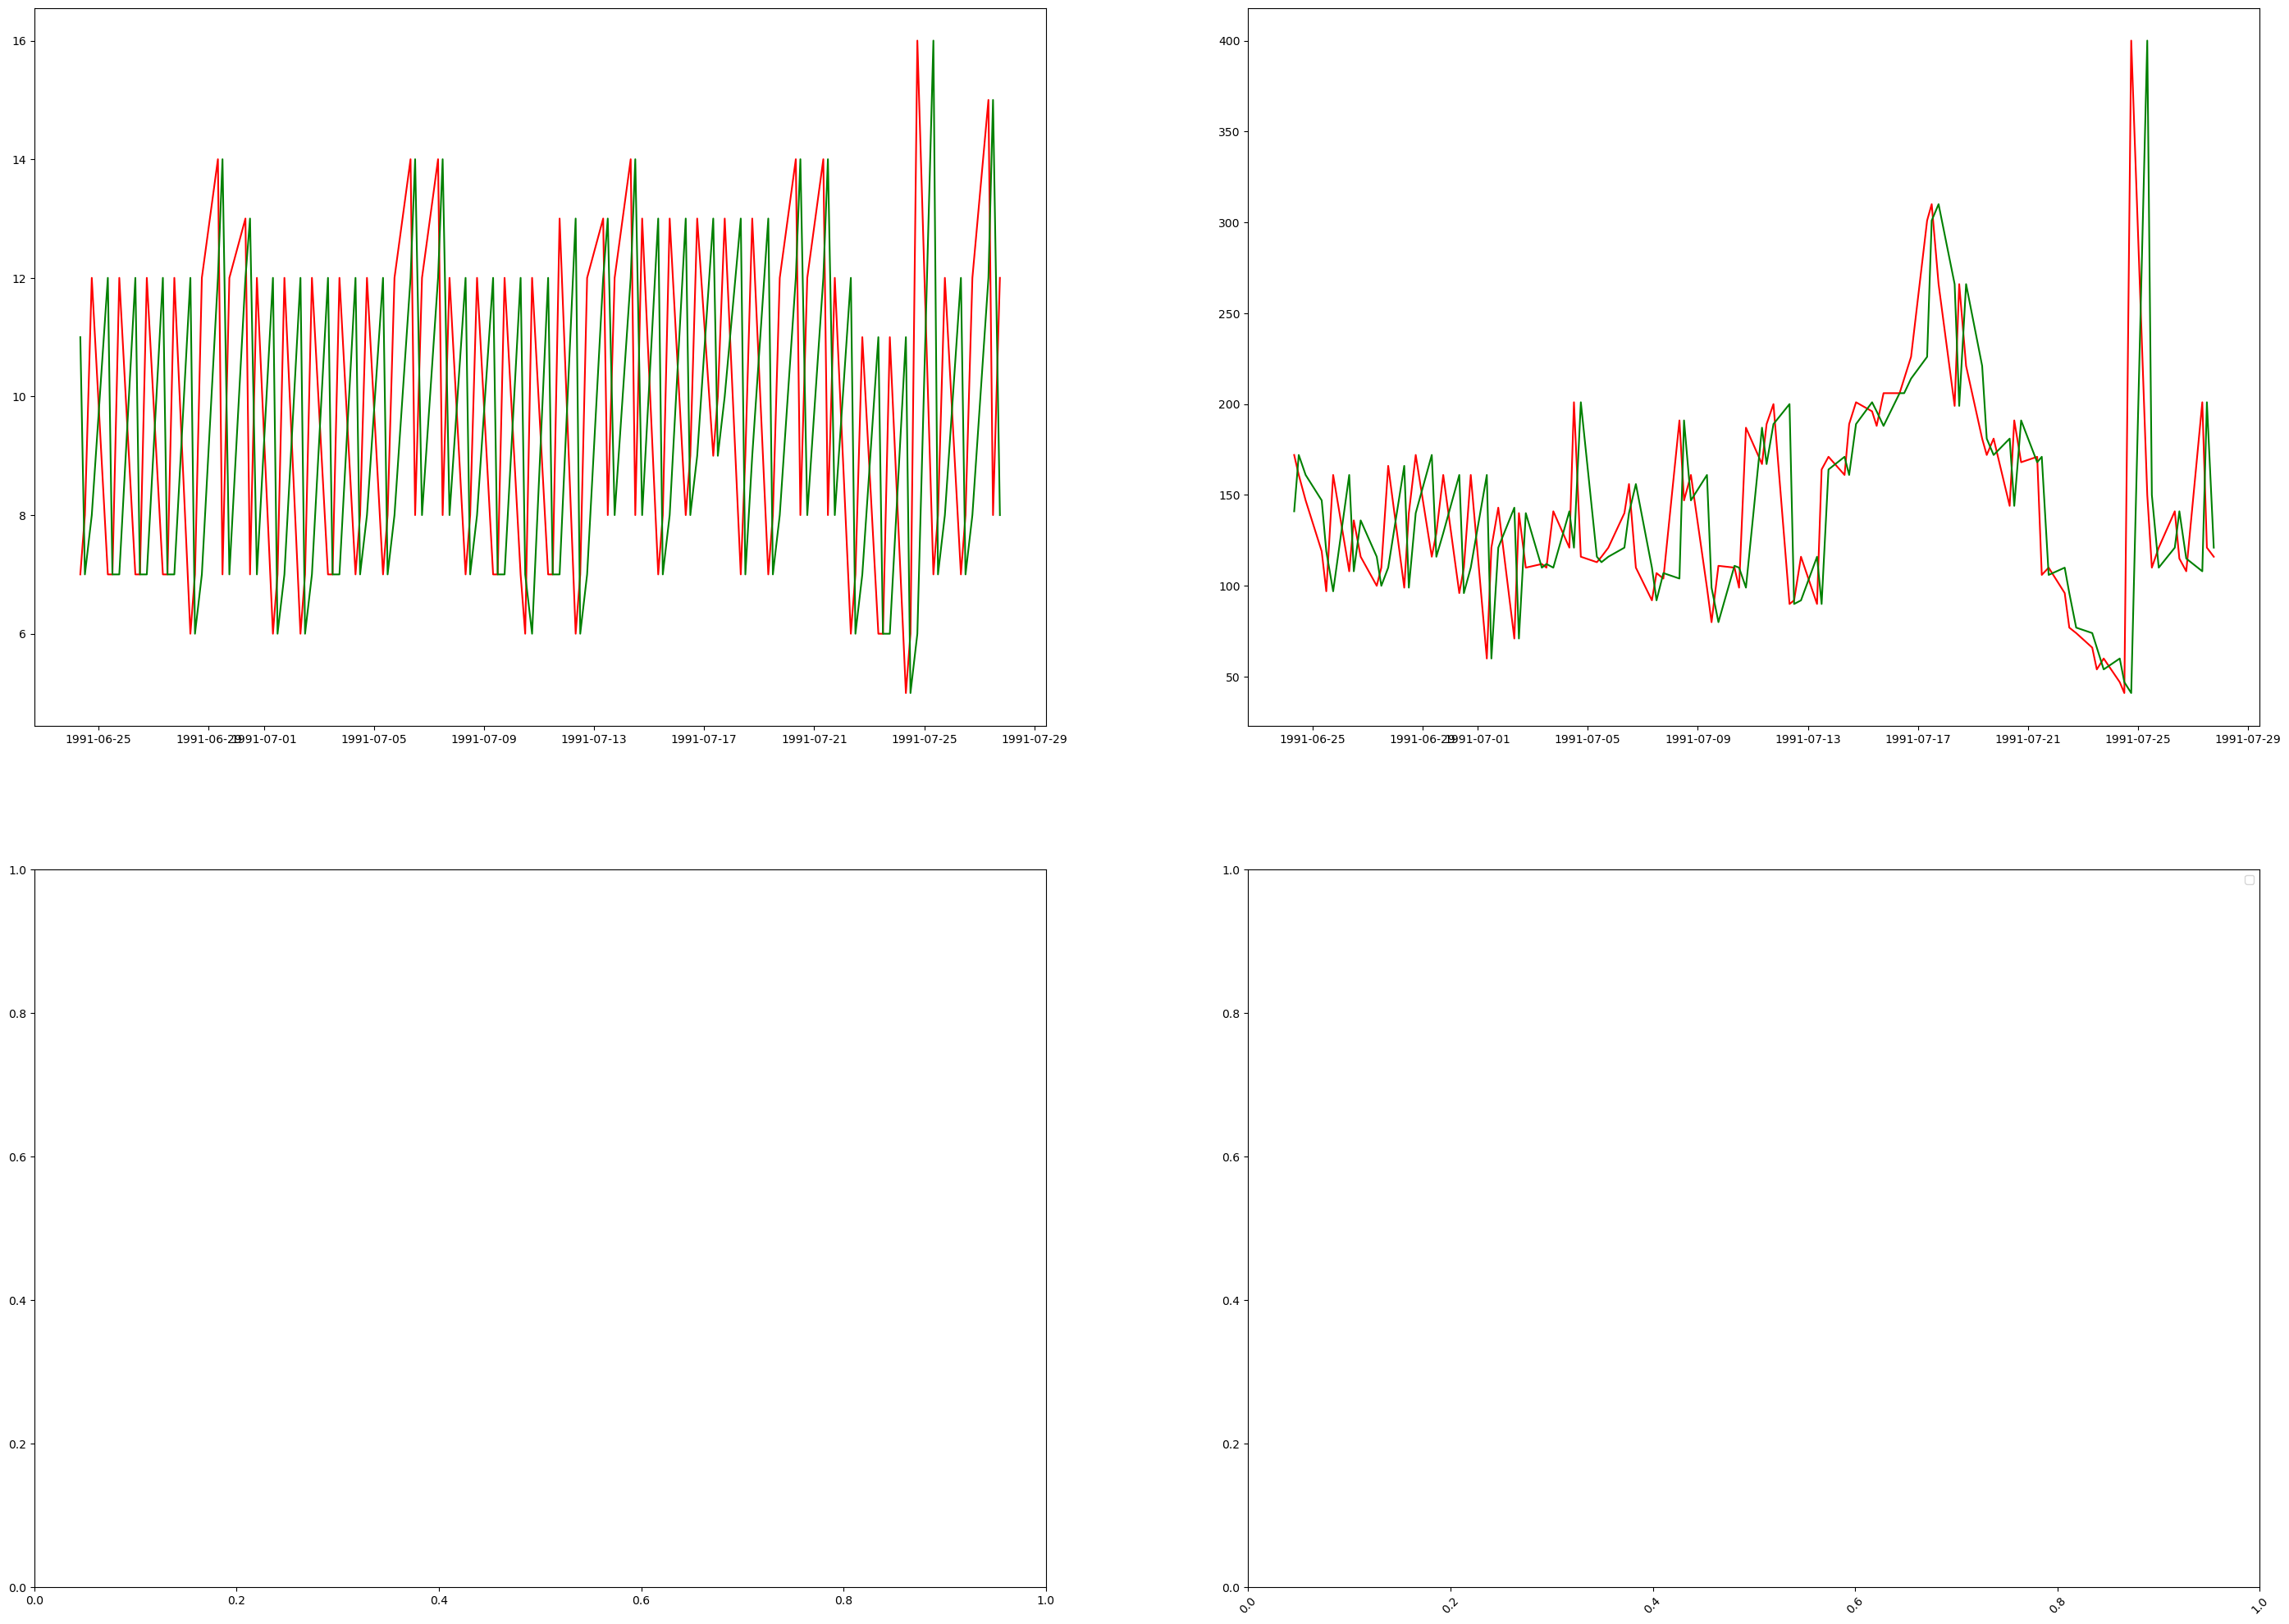

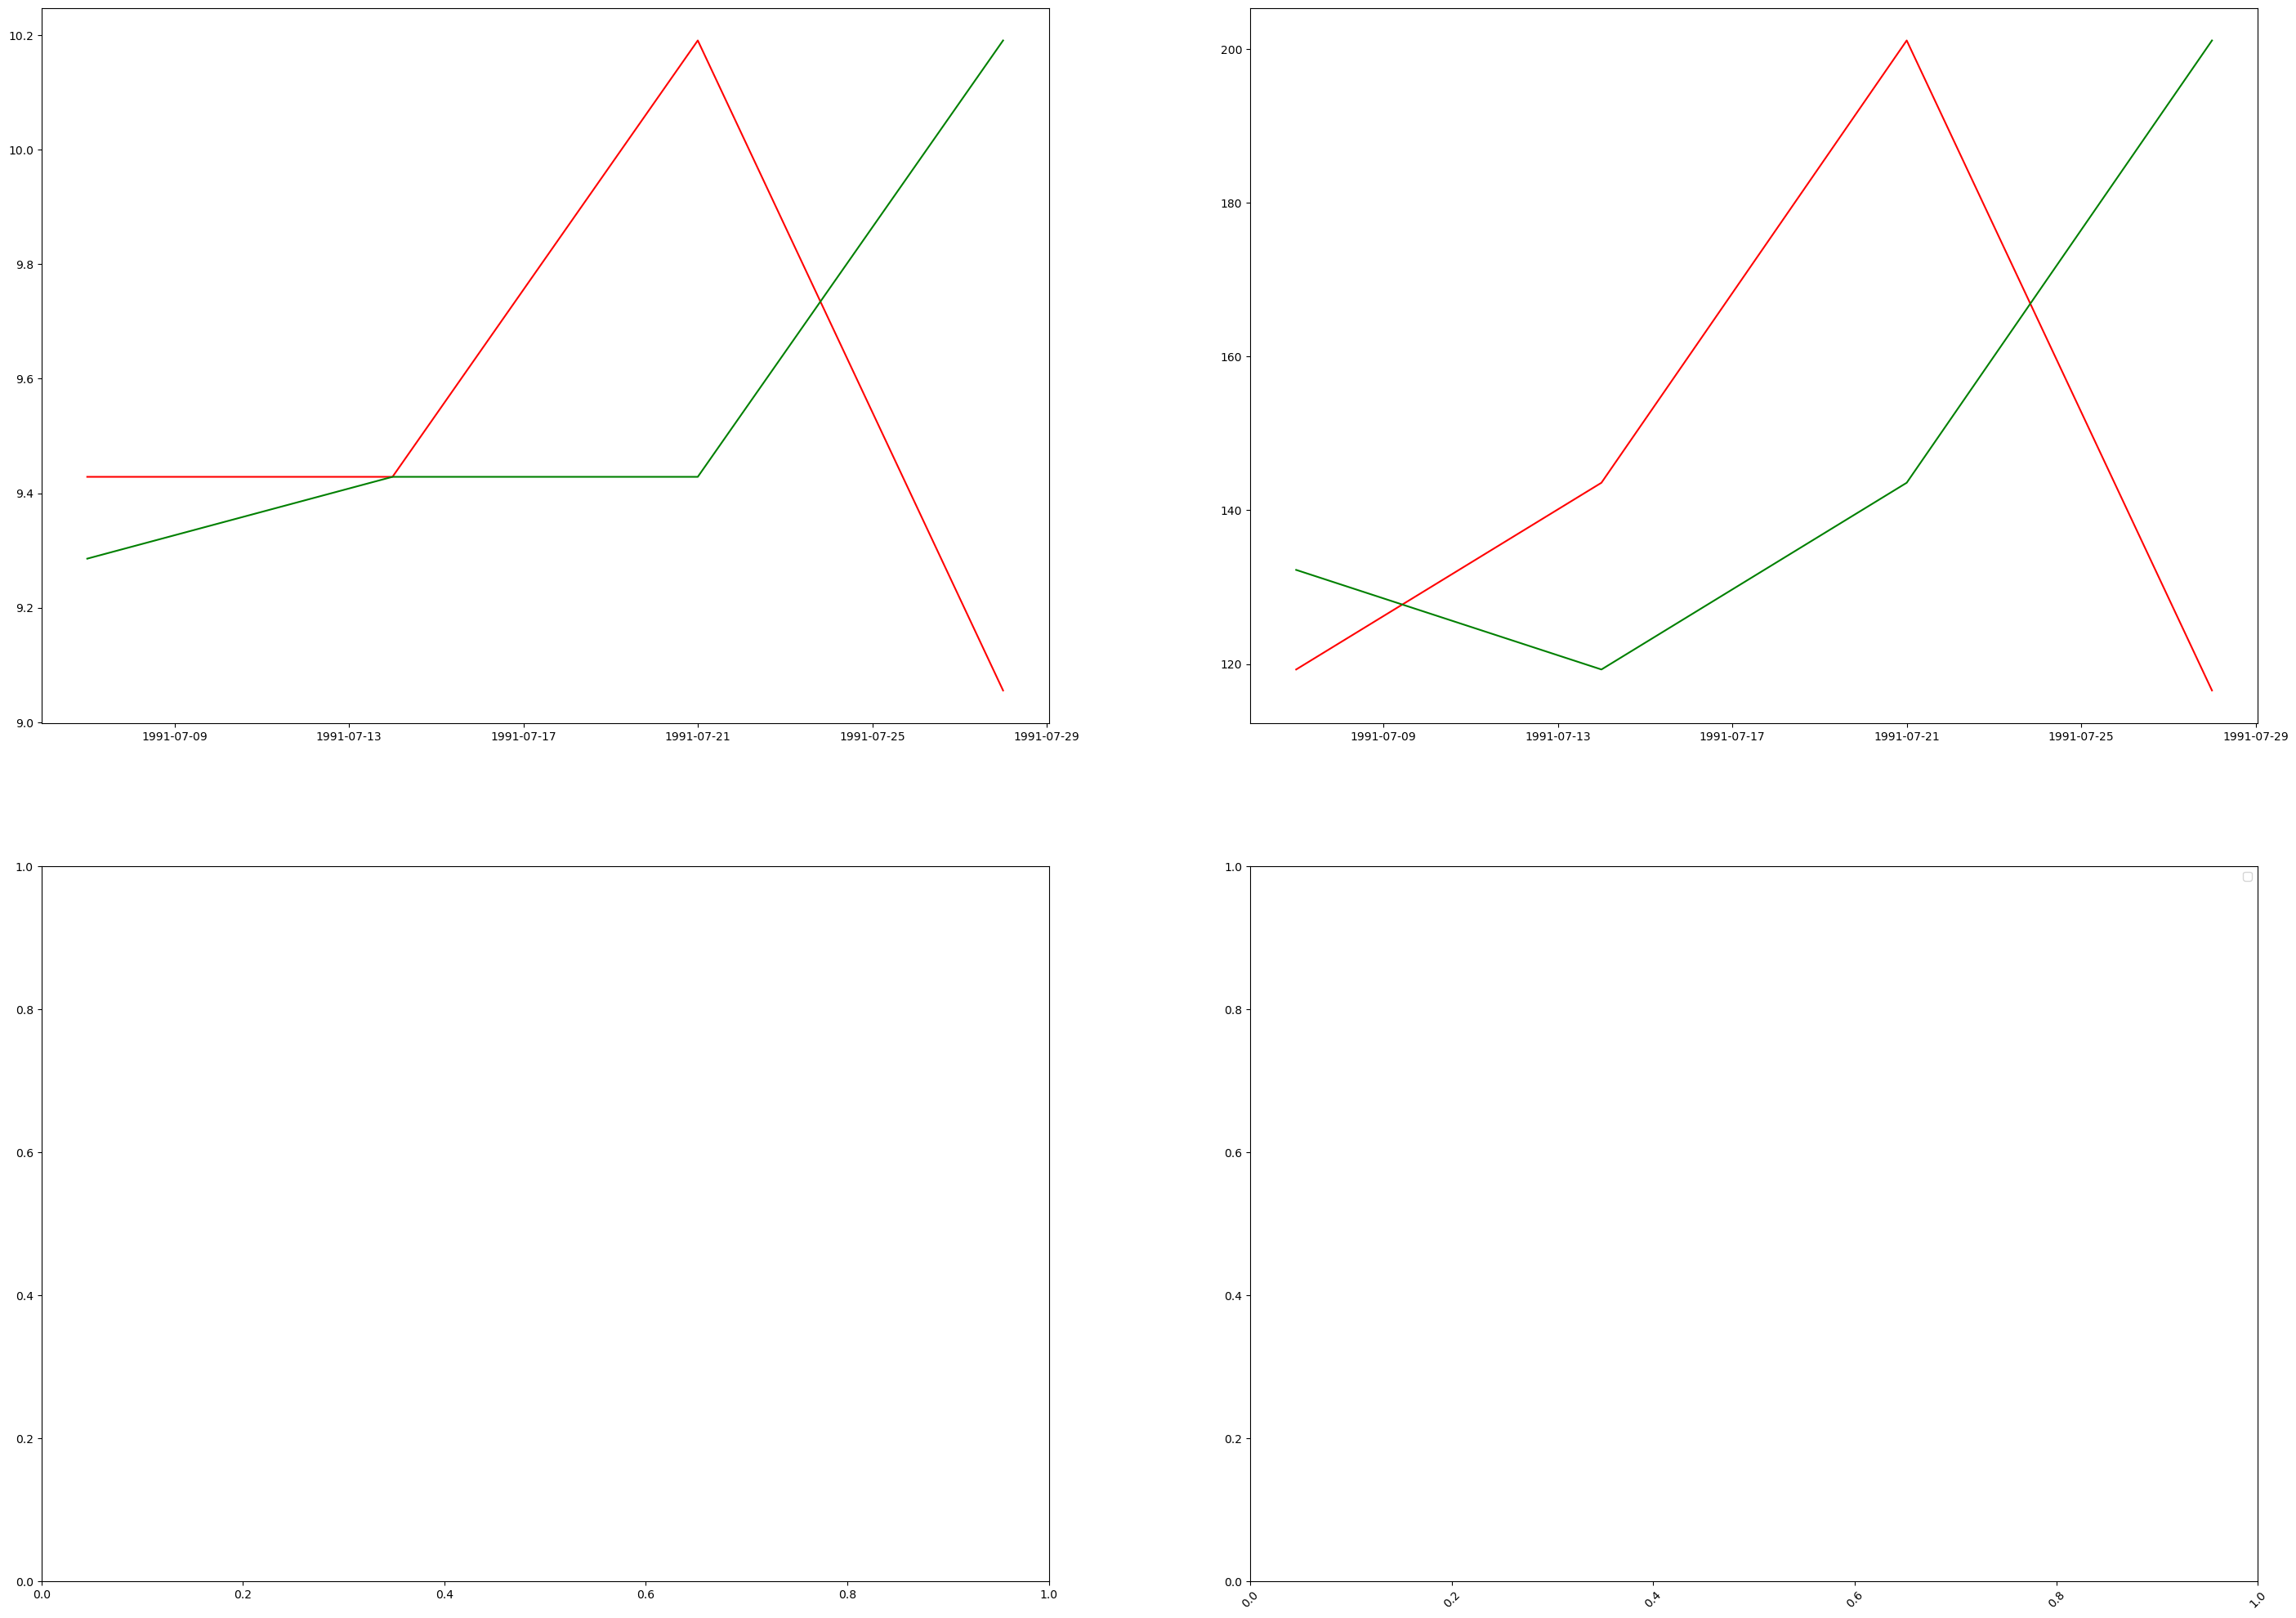

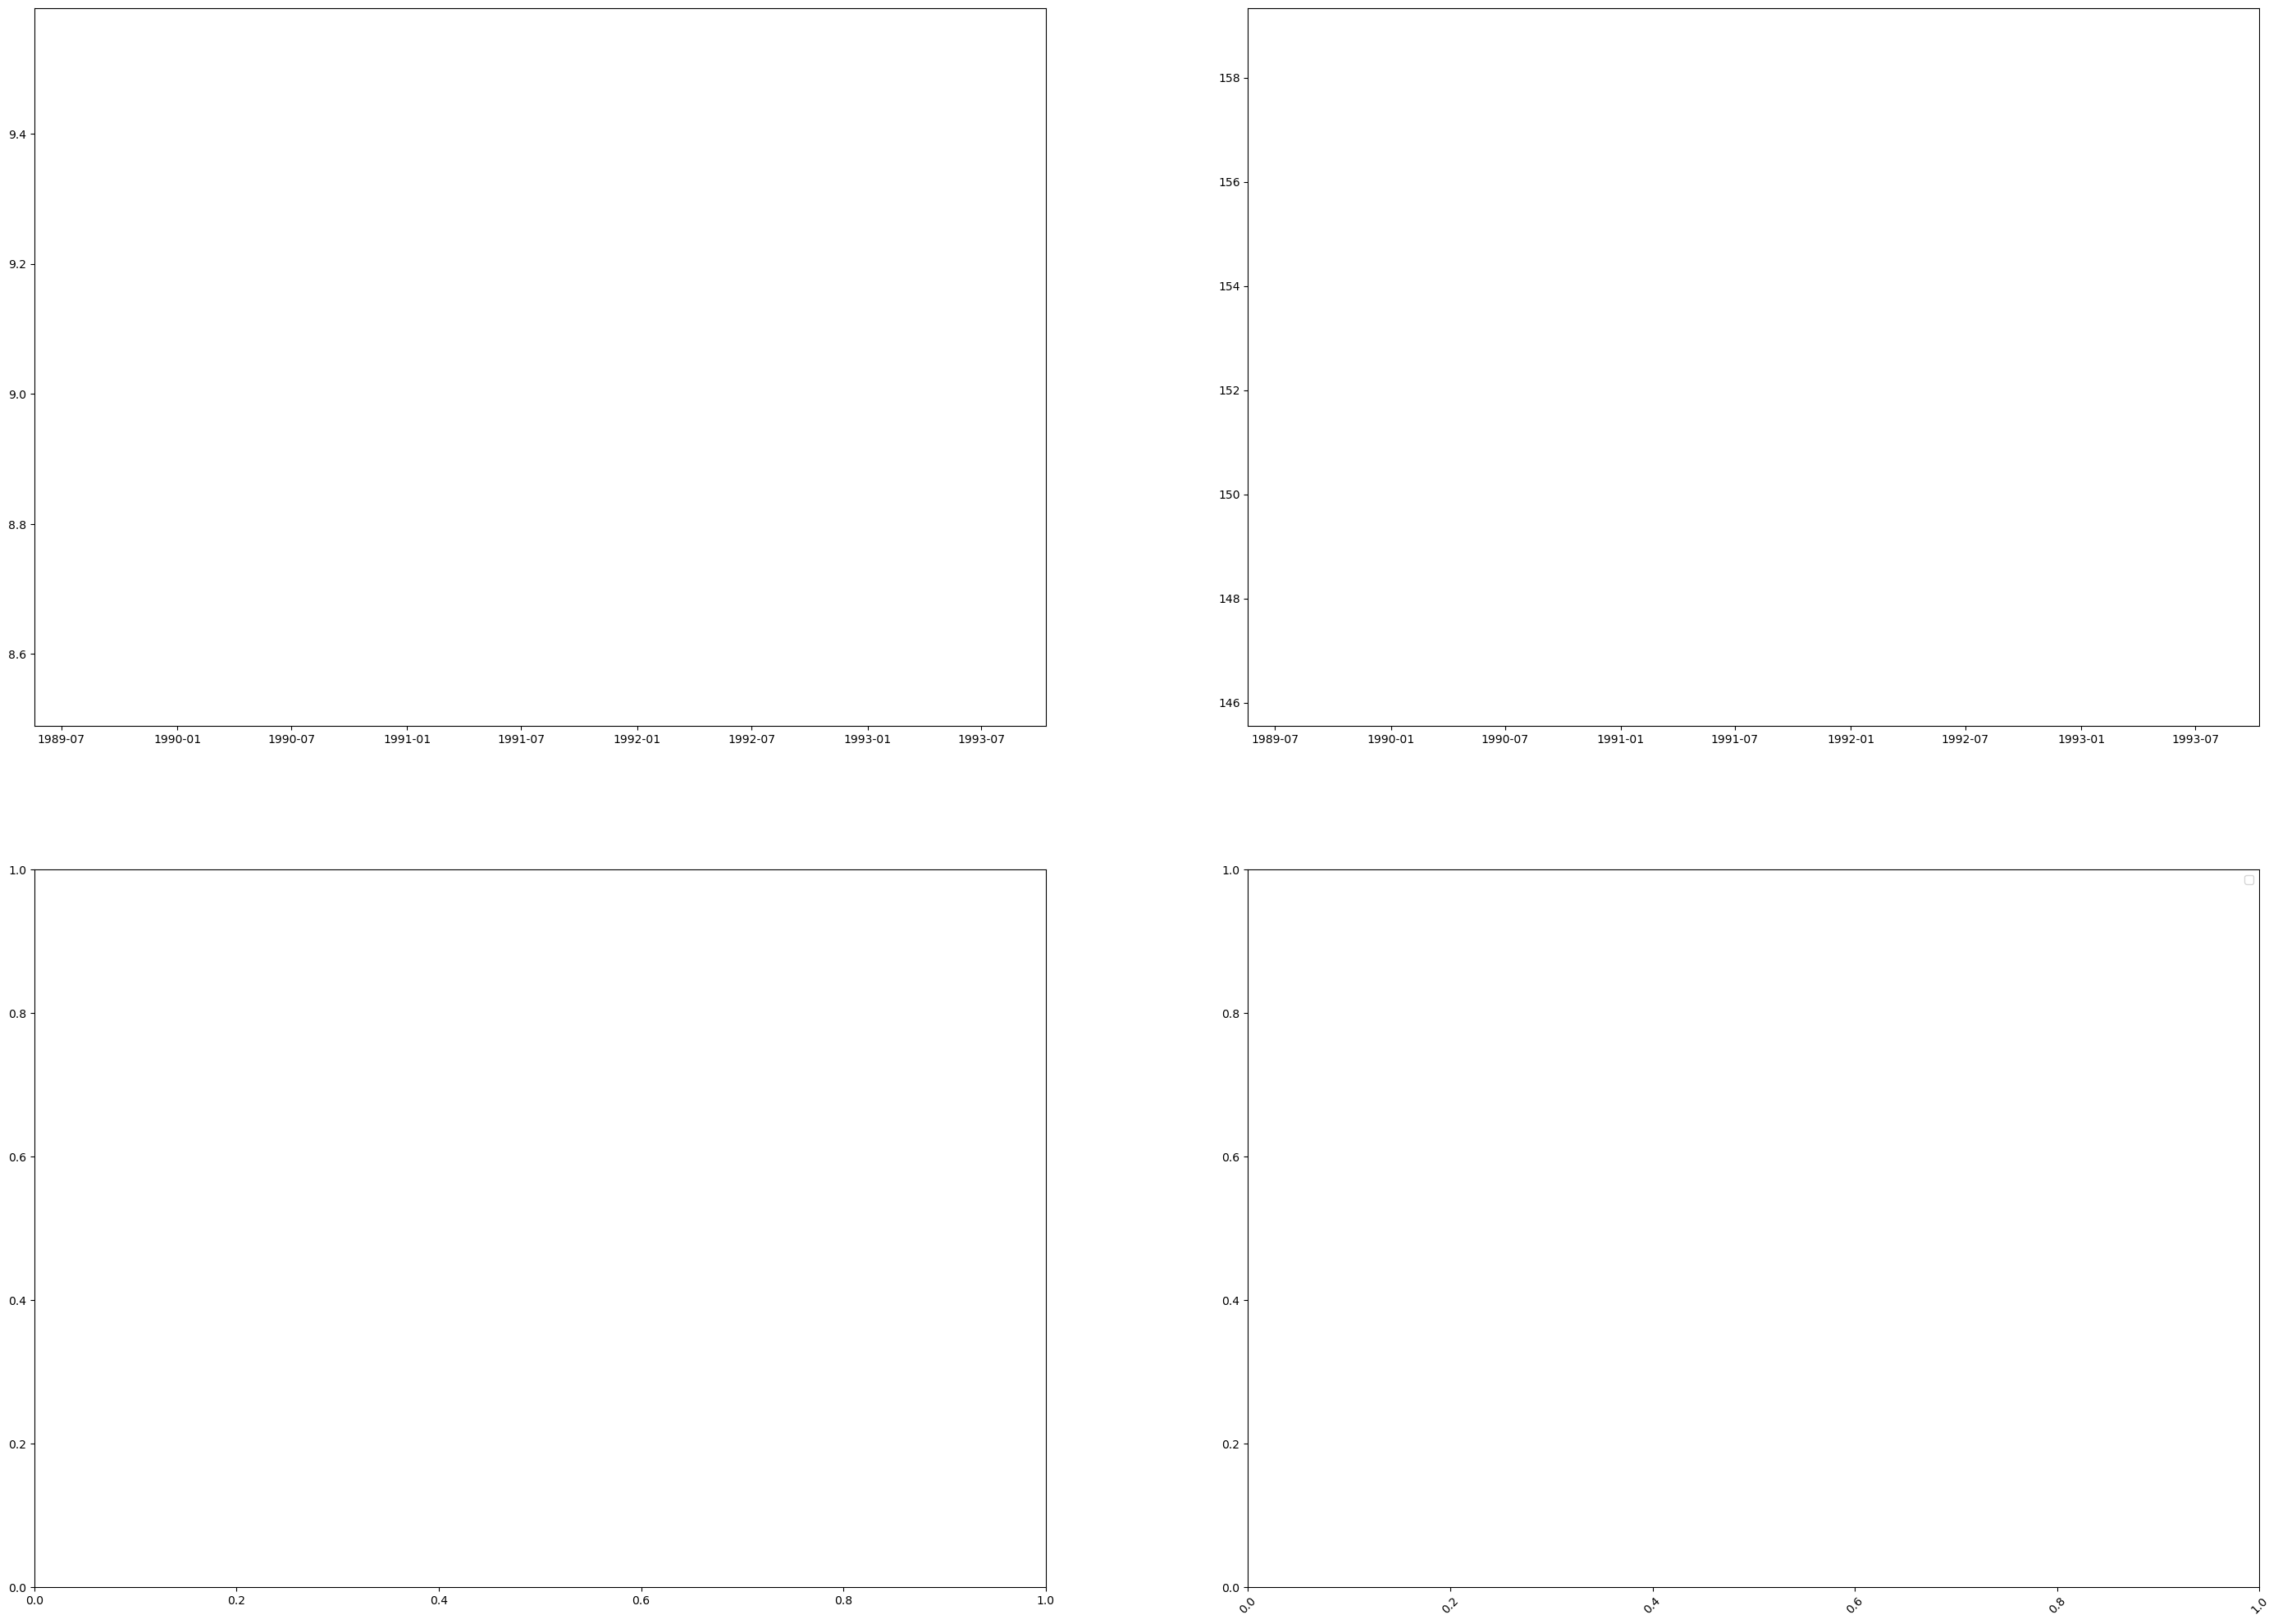

In [58]:
plot_persistence(data_daily_persistenceRes, daily_data.columns, 'drought_forecasting_persistence_daily', (2, 2))
plot_persistence(data_weekly_persistenceRes, daily_data.columns, 'drought_forecasting_persistence_weekly', (2, 2))
plot_persistence(data_monthly_persistenceRes, daily_data.columns, 'drought_forecasting_persistence_monthly', (2, 2))

In [51]:
# smoothing
def smooth_sg1(data, frac, p, filename, dimension):

    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    data_filtered = []
    for pos in range(len(data.columns)):
        x = data[data.columns[pos]]
        w = int(len(x)*frac)
        x_filtered = savgol_filter(x, w, p)
        data_filtered.append(x_filtered)

        pos_i = pos//j
        pos_j = pos%j

        ax[pos_i][pos_j].plot(x)
        ax[pos_i][pos_j].plot(x_filtered, color = "green")
        plt.legend(x)
        #plt.xticks(rotation=45)

    
    plt.savefig('plots/' + filename + '.png')
    return data_filtered

In [52]:
def ses(data, s_level, filename, dimension):

    i, j = dimension
    fig, ax = plt.subplots(i, j, figsize=(35, 25))
    data_filtered = []
    

    for pos in range(len(data.columns)):

        x = data[data.columns[pos]]
        model = SimpleExpSmoothing(x)
        x_filtered = model.fit(smoothing_level=s_level, optimized=False)
        print(x_filtered)
        data_filtered.append(x_filtered.fittedvalues)

        pos_i = pos//j
        pos_j = pos%j

        ax[pos_i][pos_j].plot(x)
        ax[pos_i][pos_j].plot(x_filtered.fittedvalues, color = "green")
        plt.legend(x)
        #plt.xticks(rotation=45)

    
    plt.savefig('plots/' + filename + '.png')
    return data_filtered

C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\viniv\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


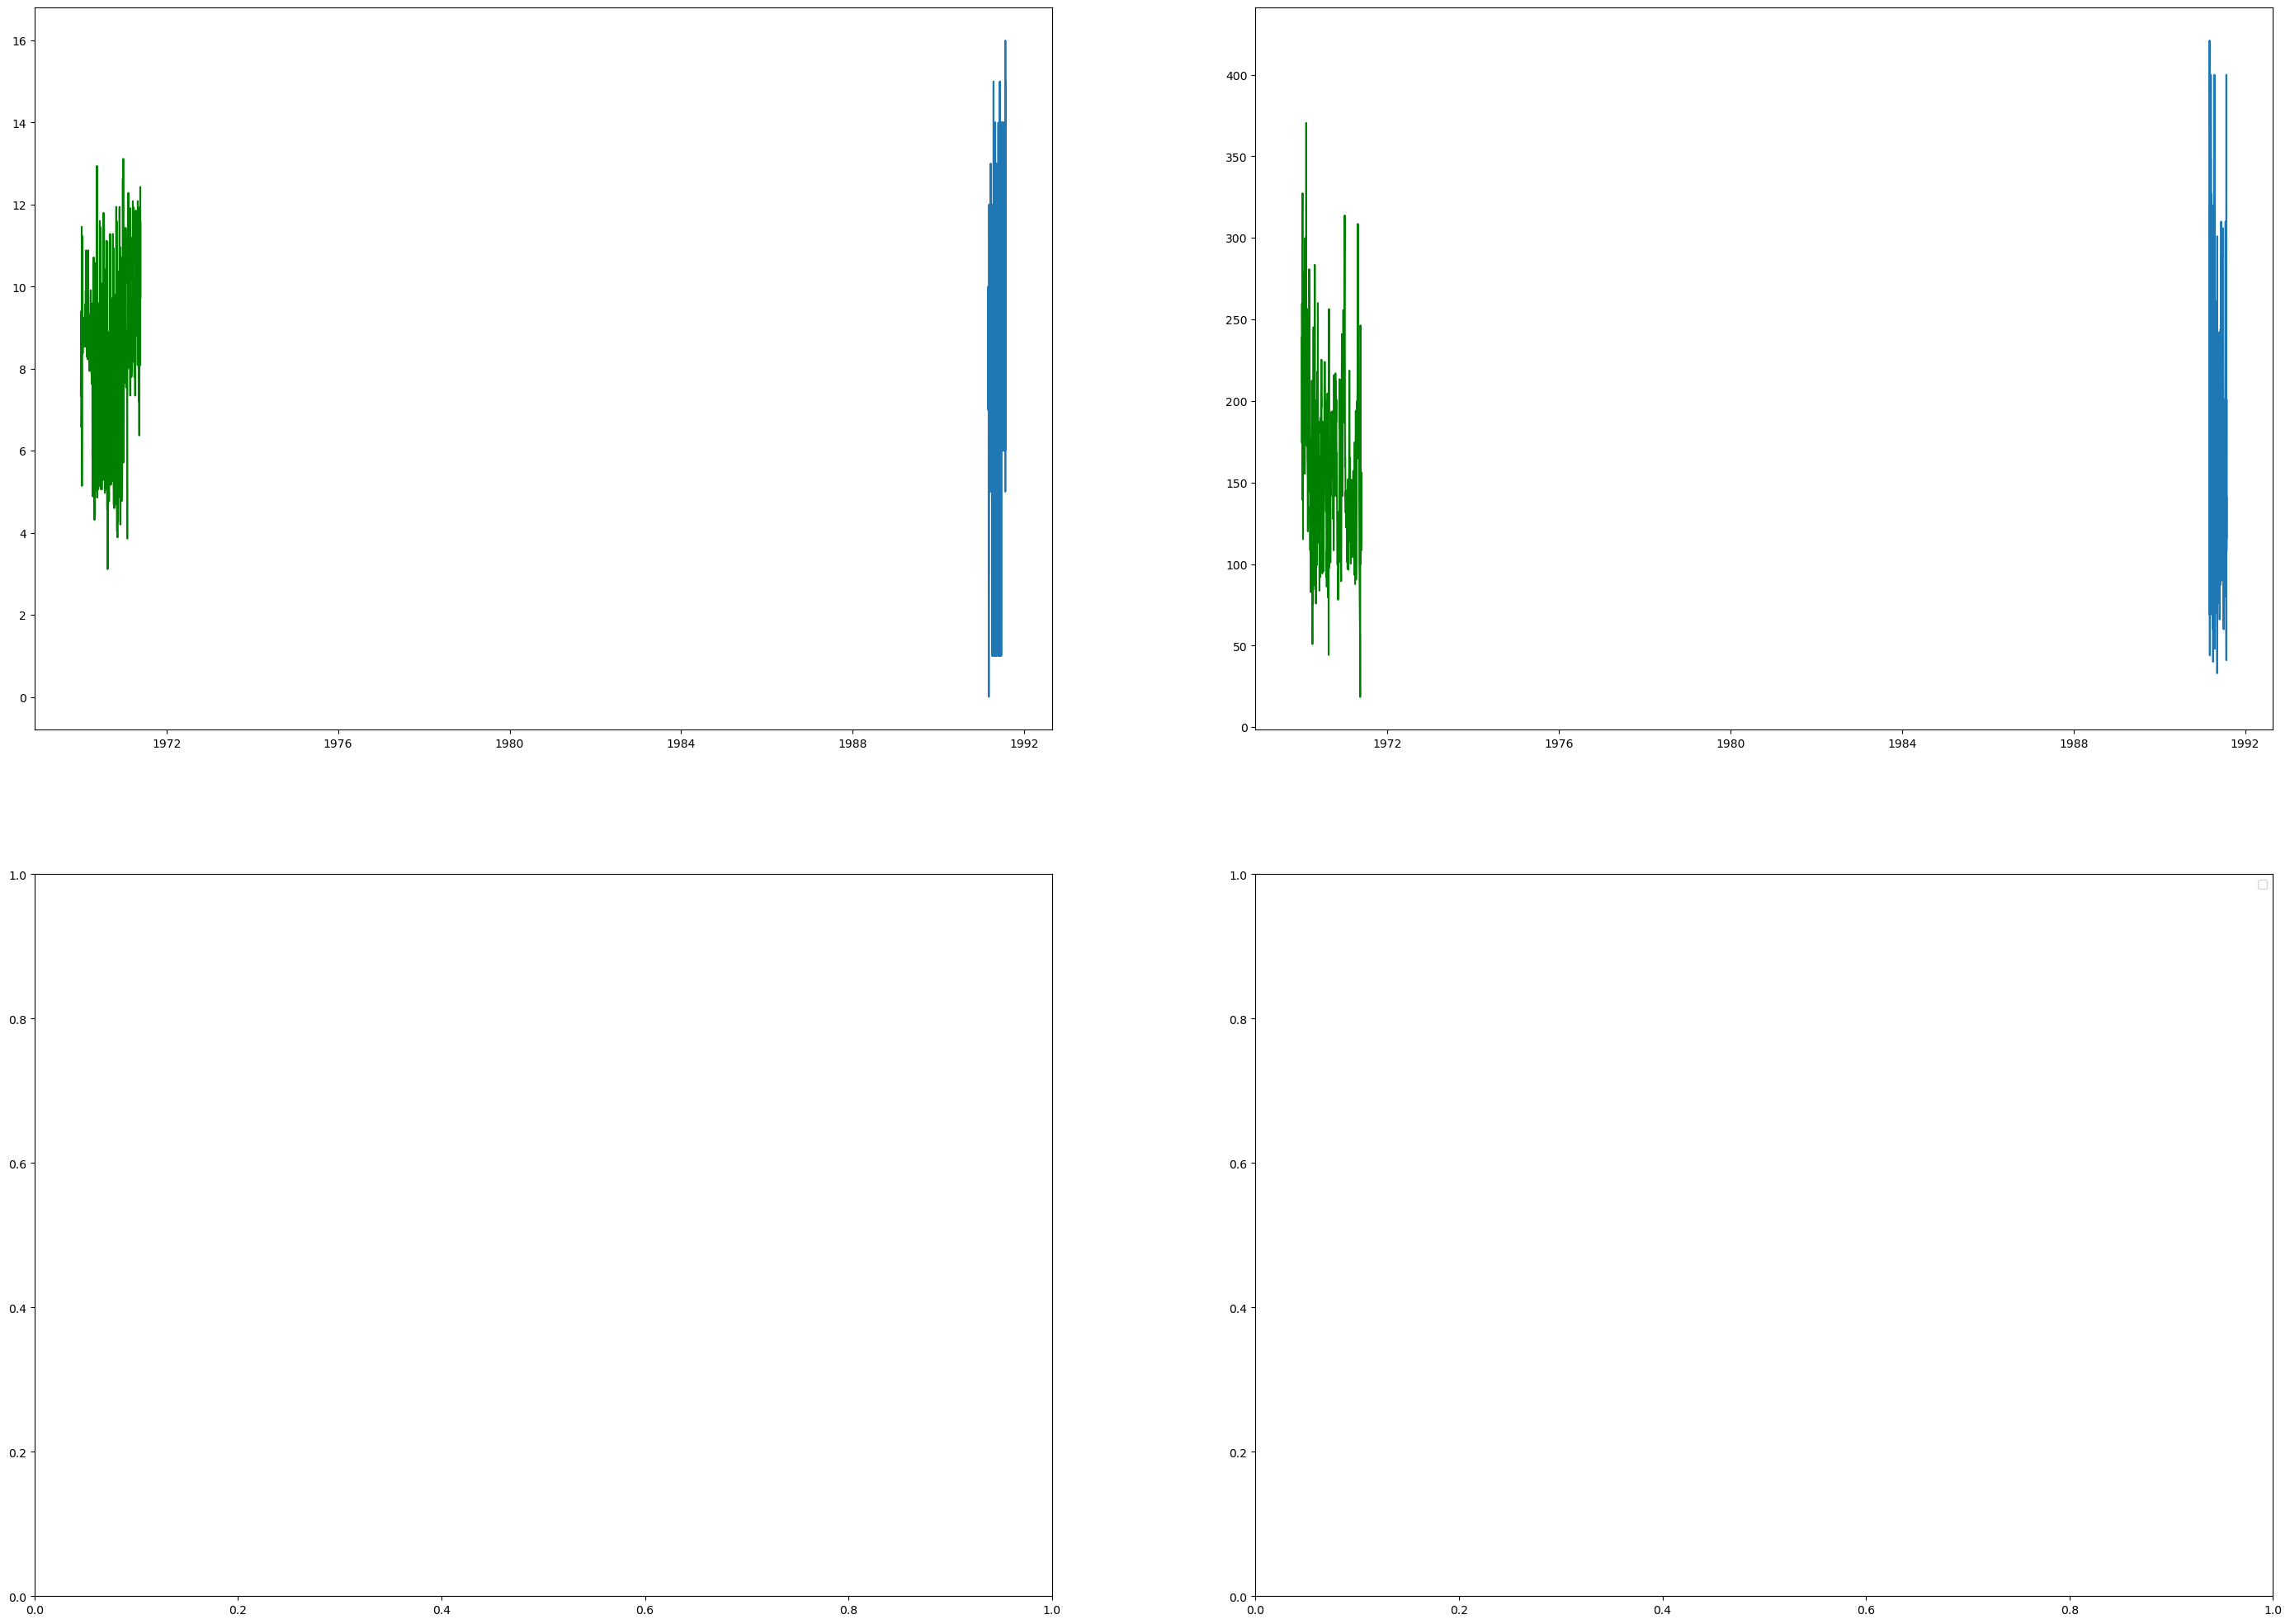

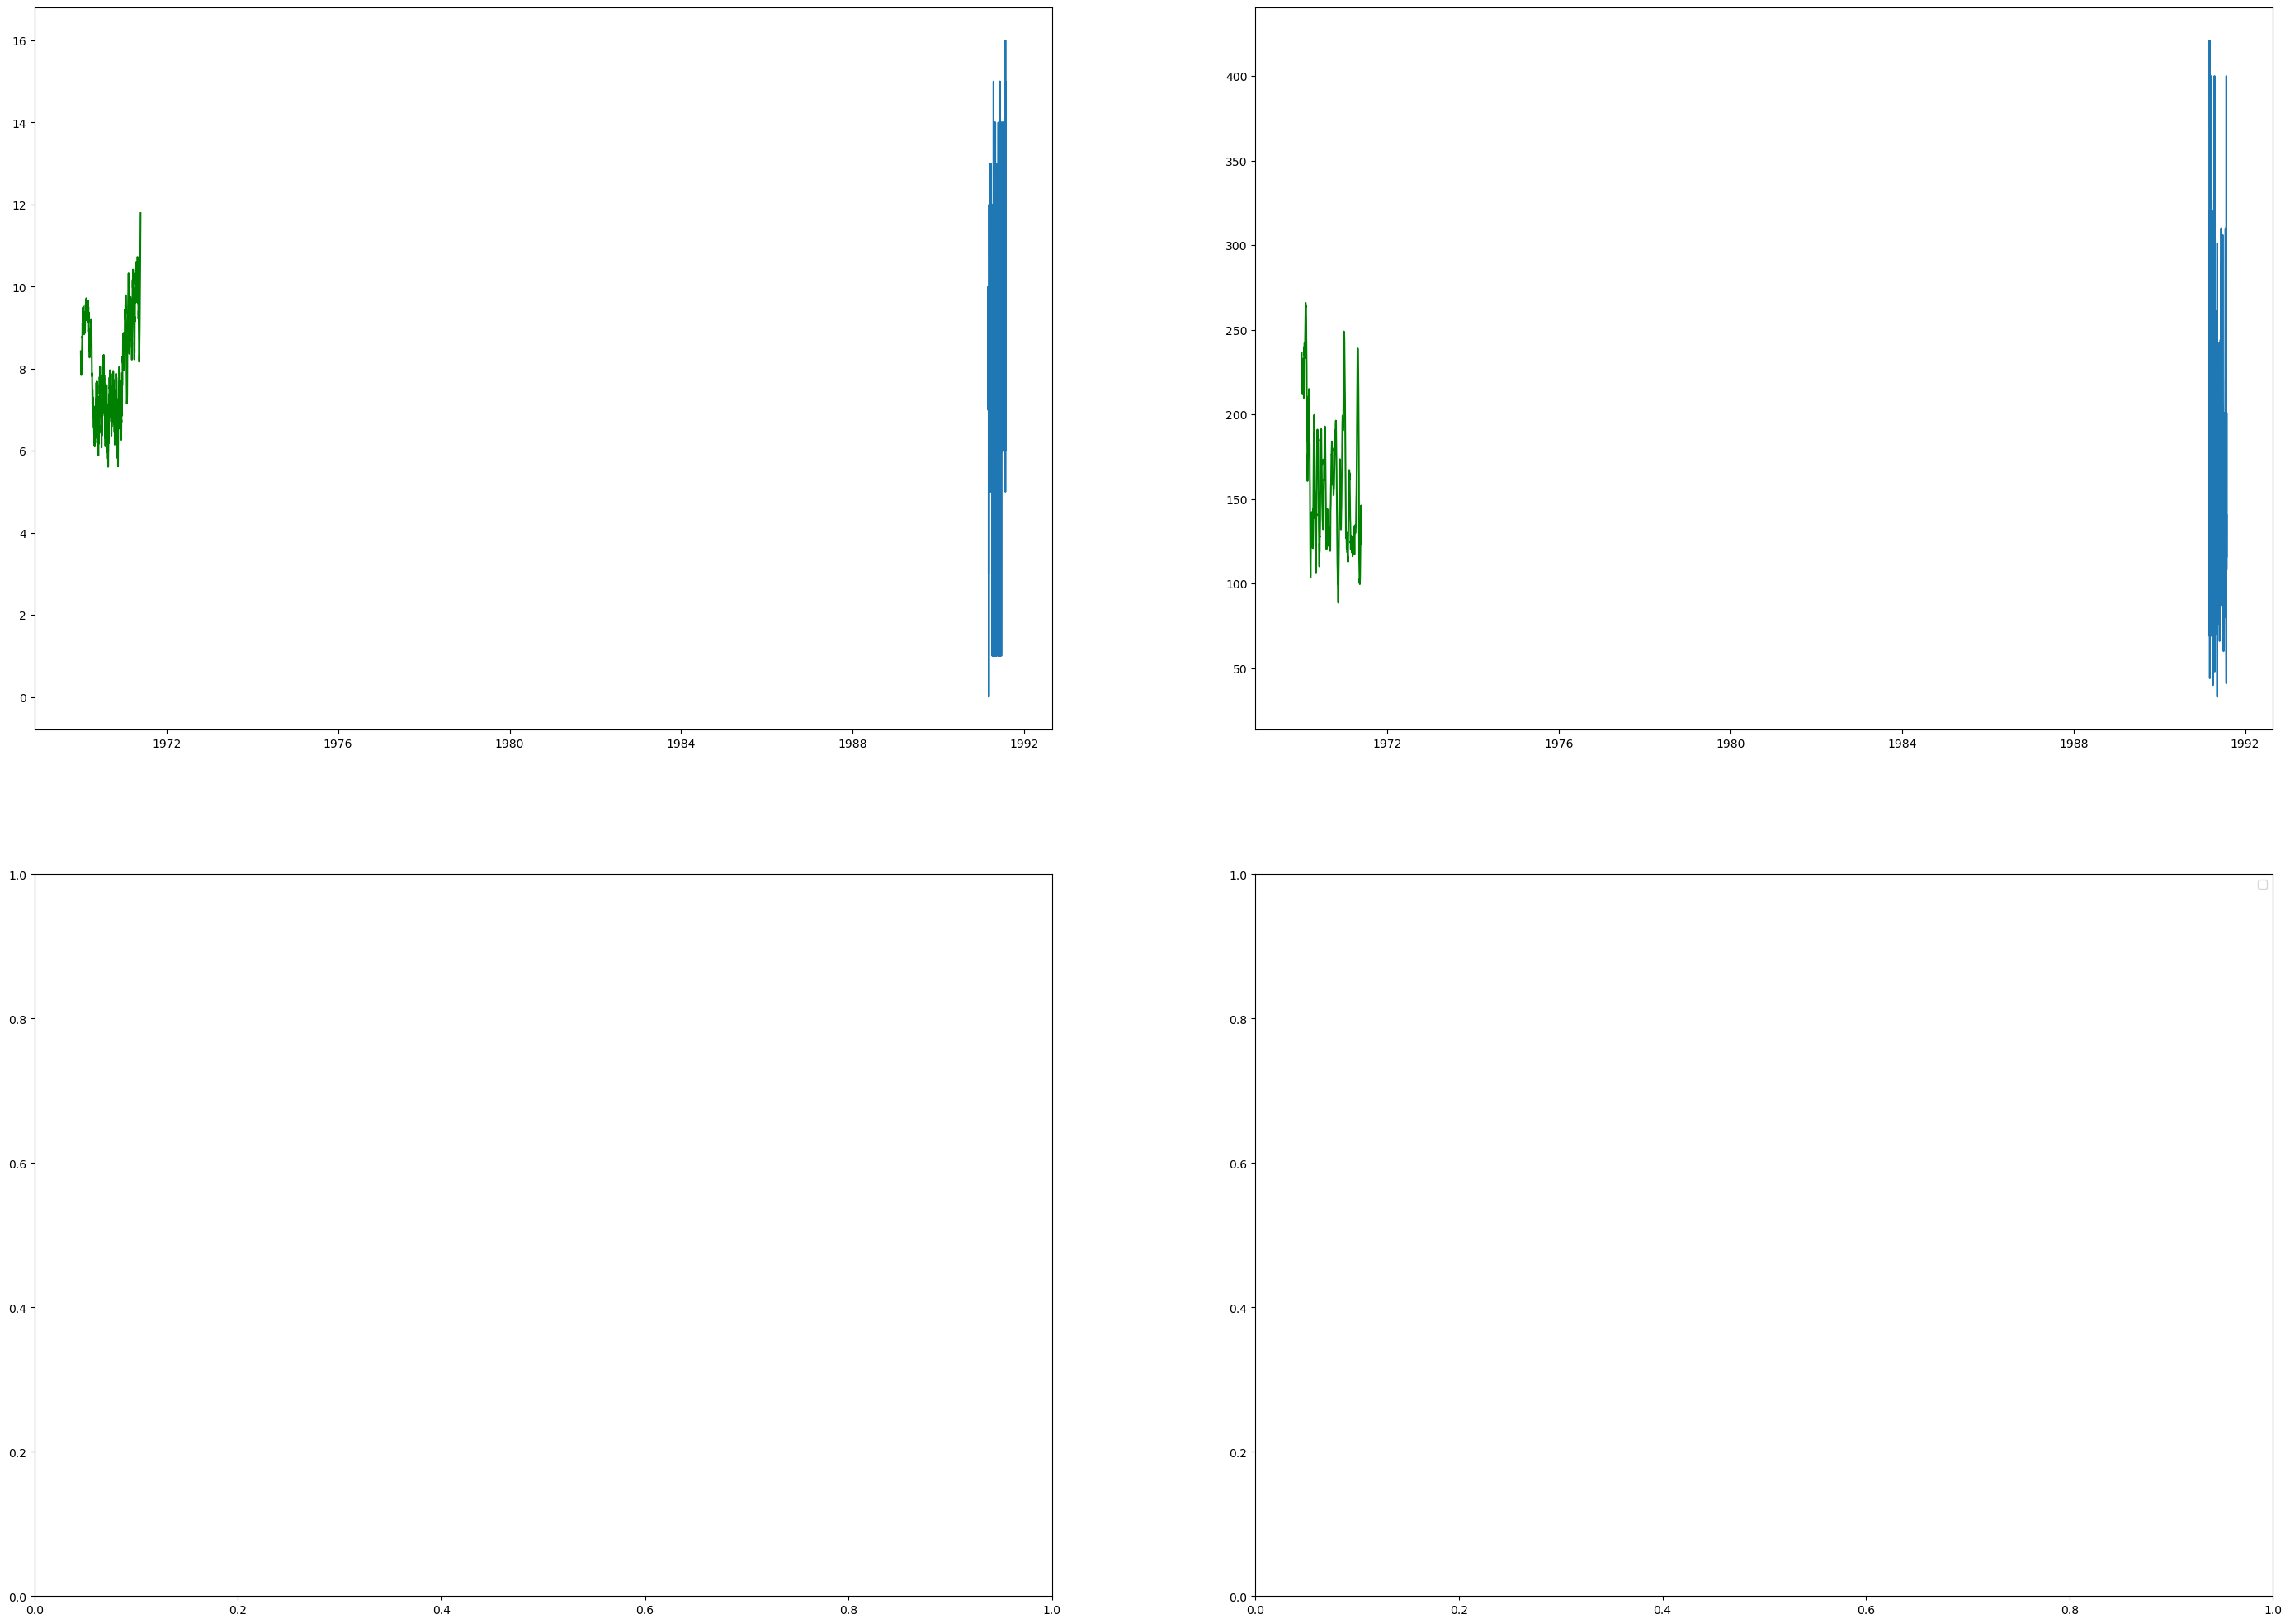

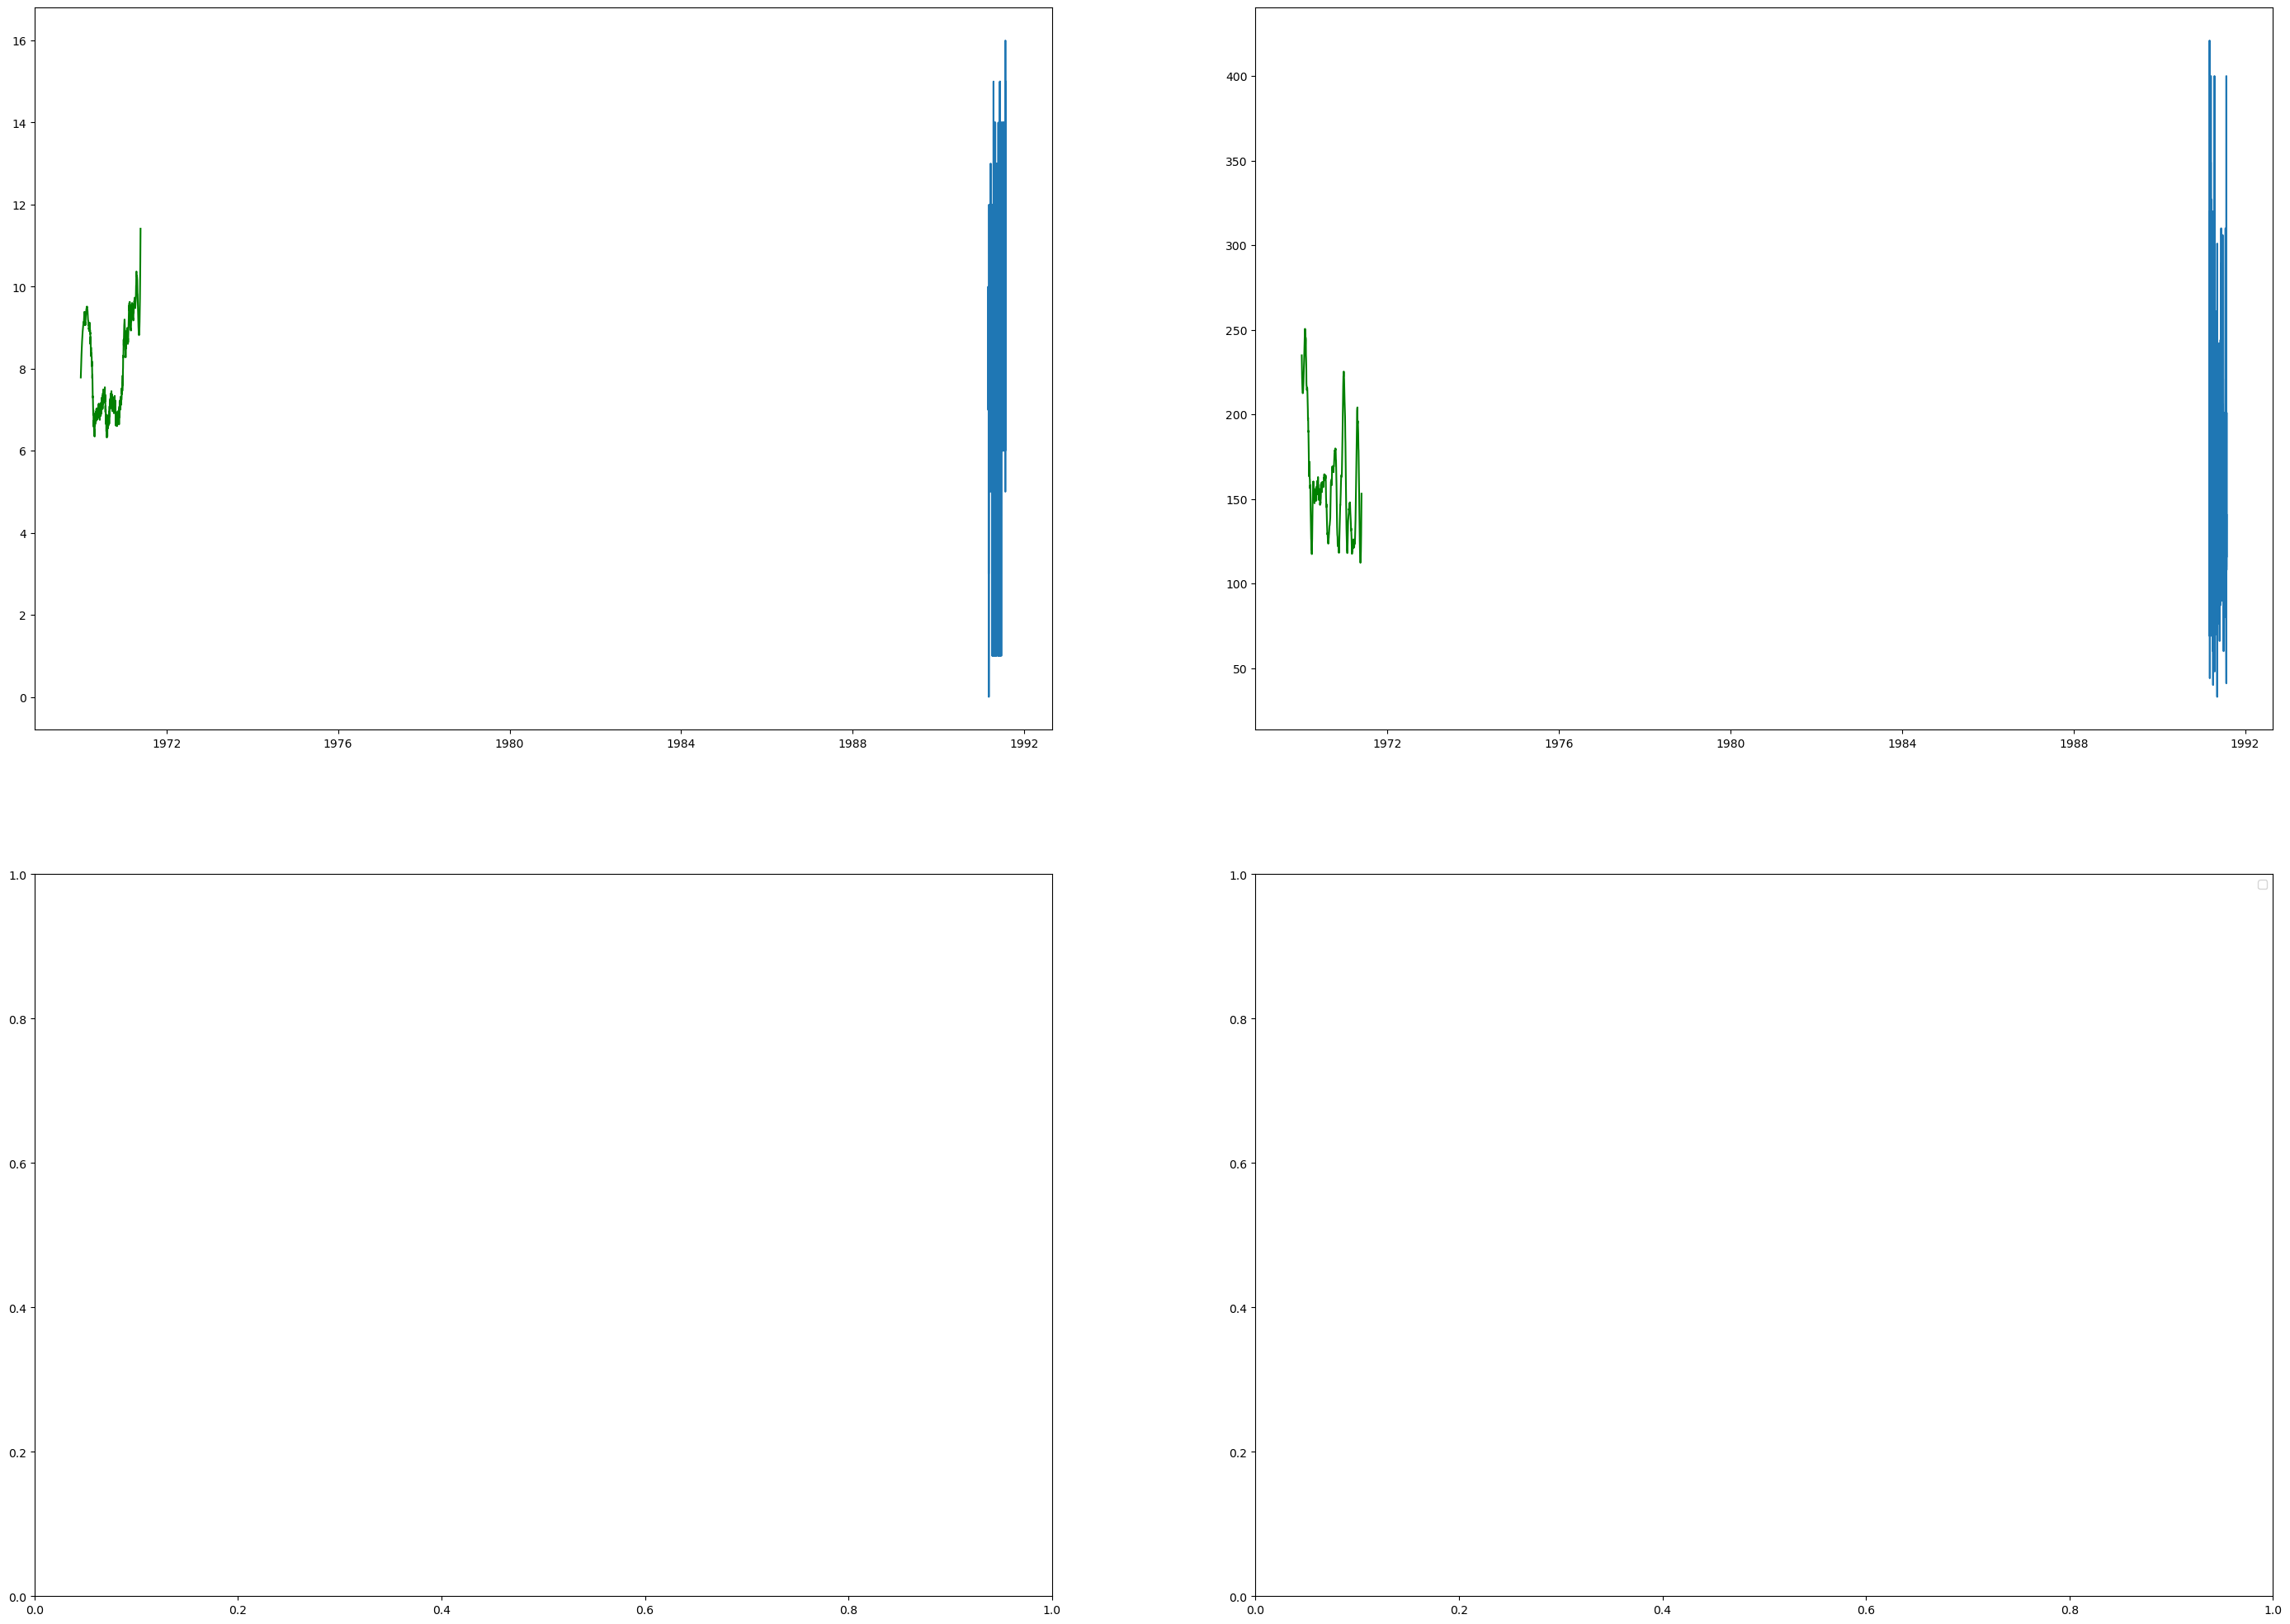

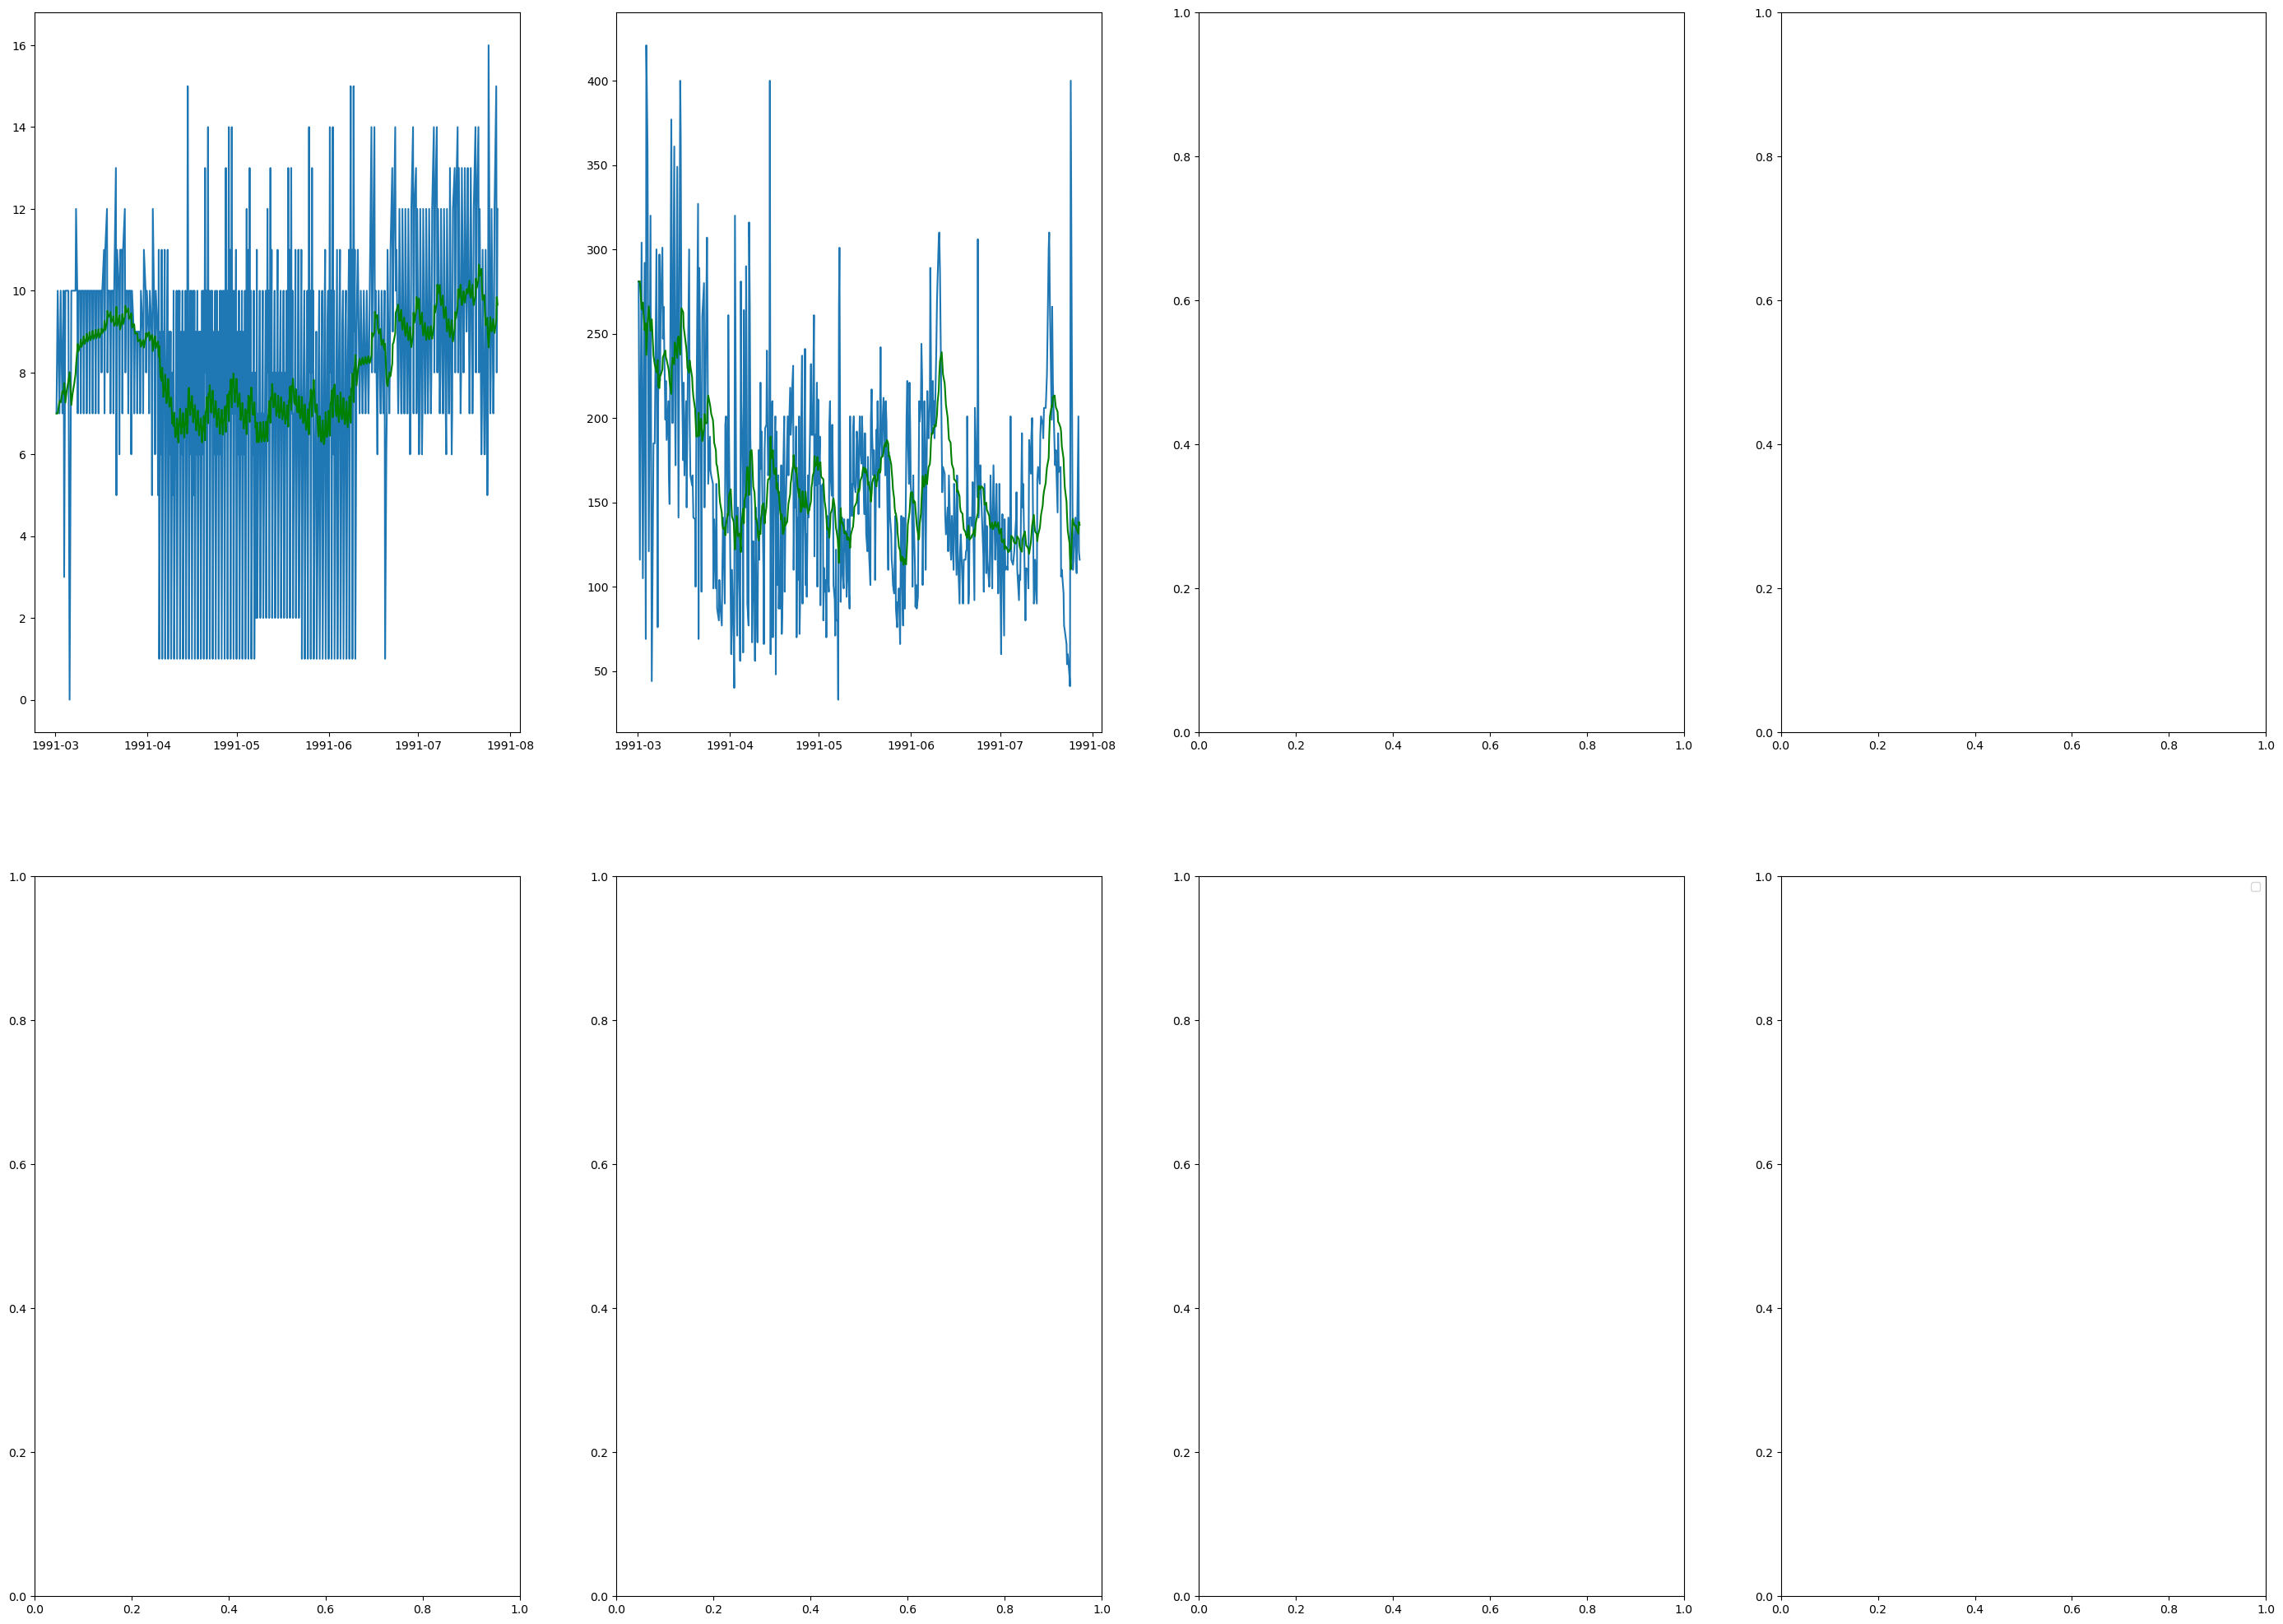

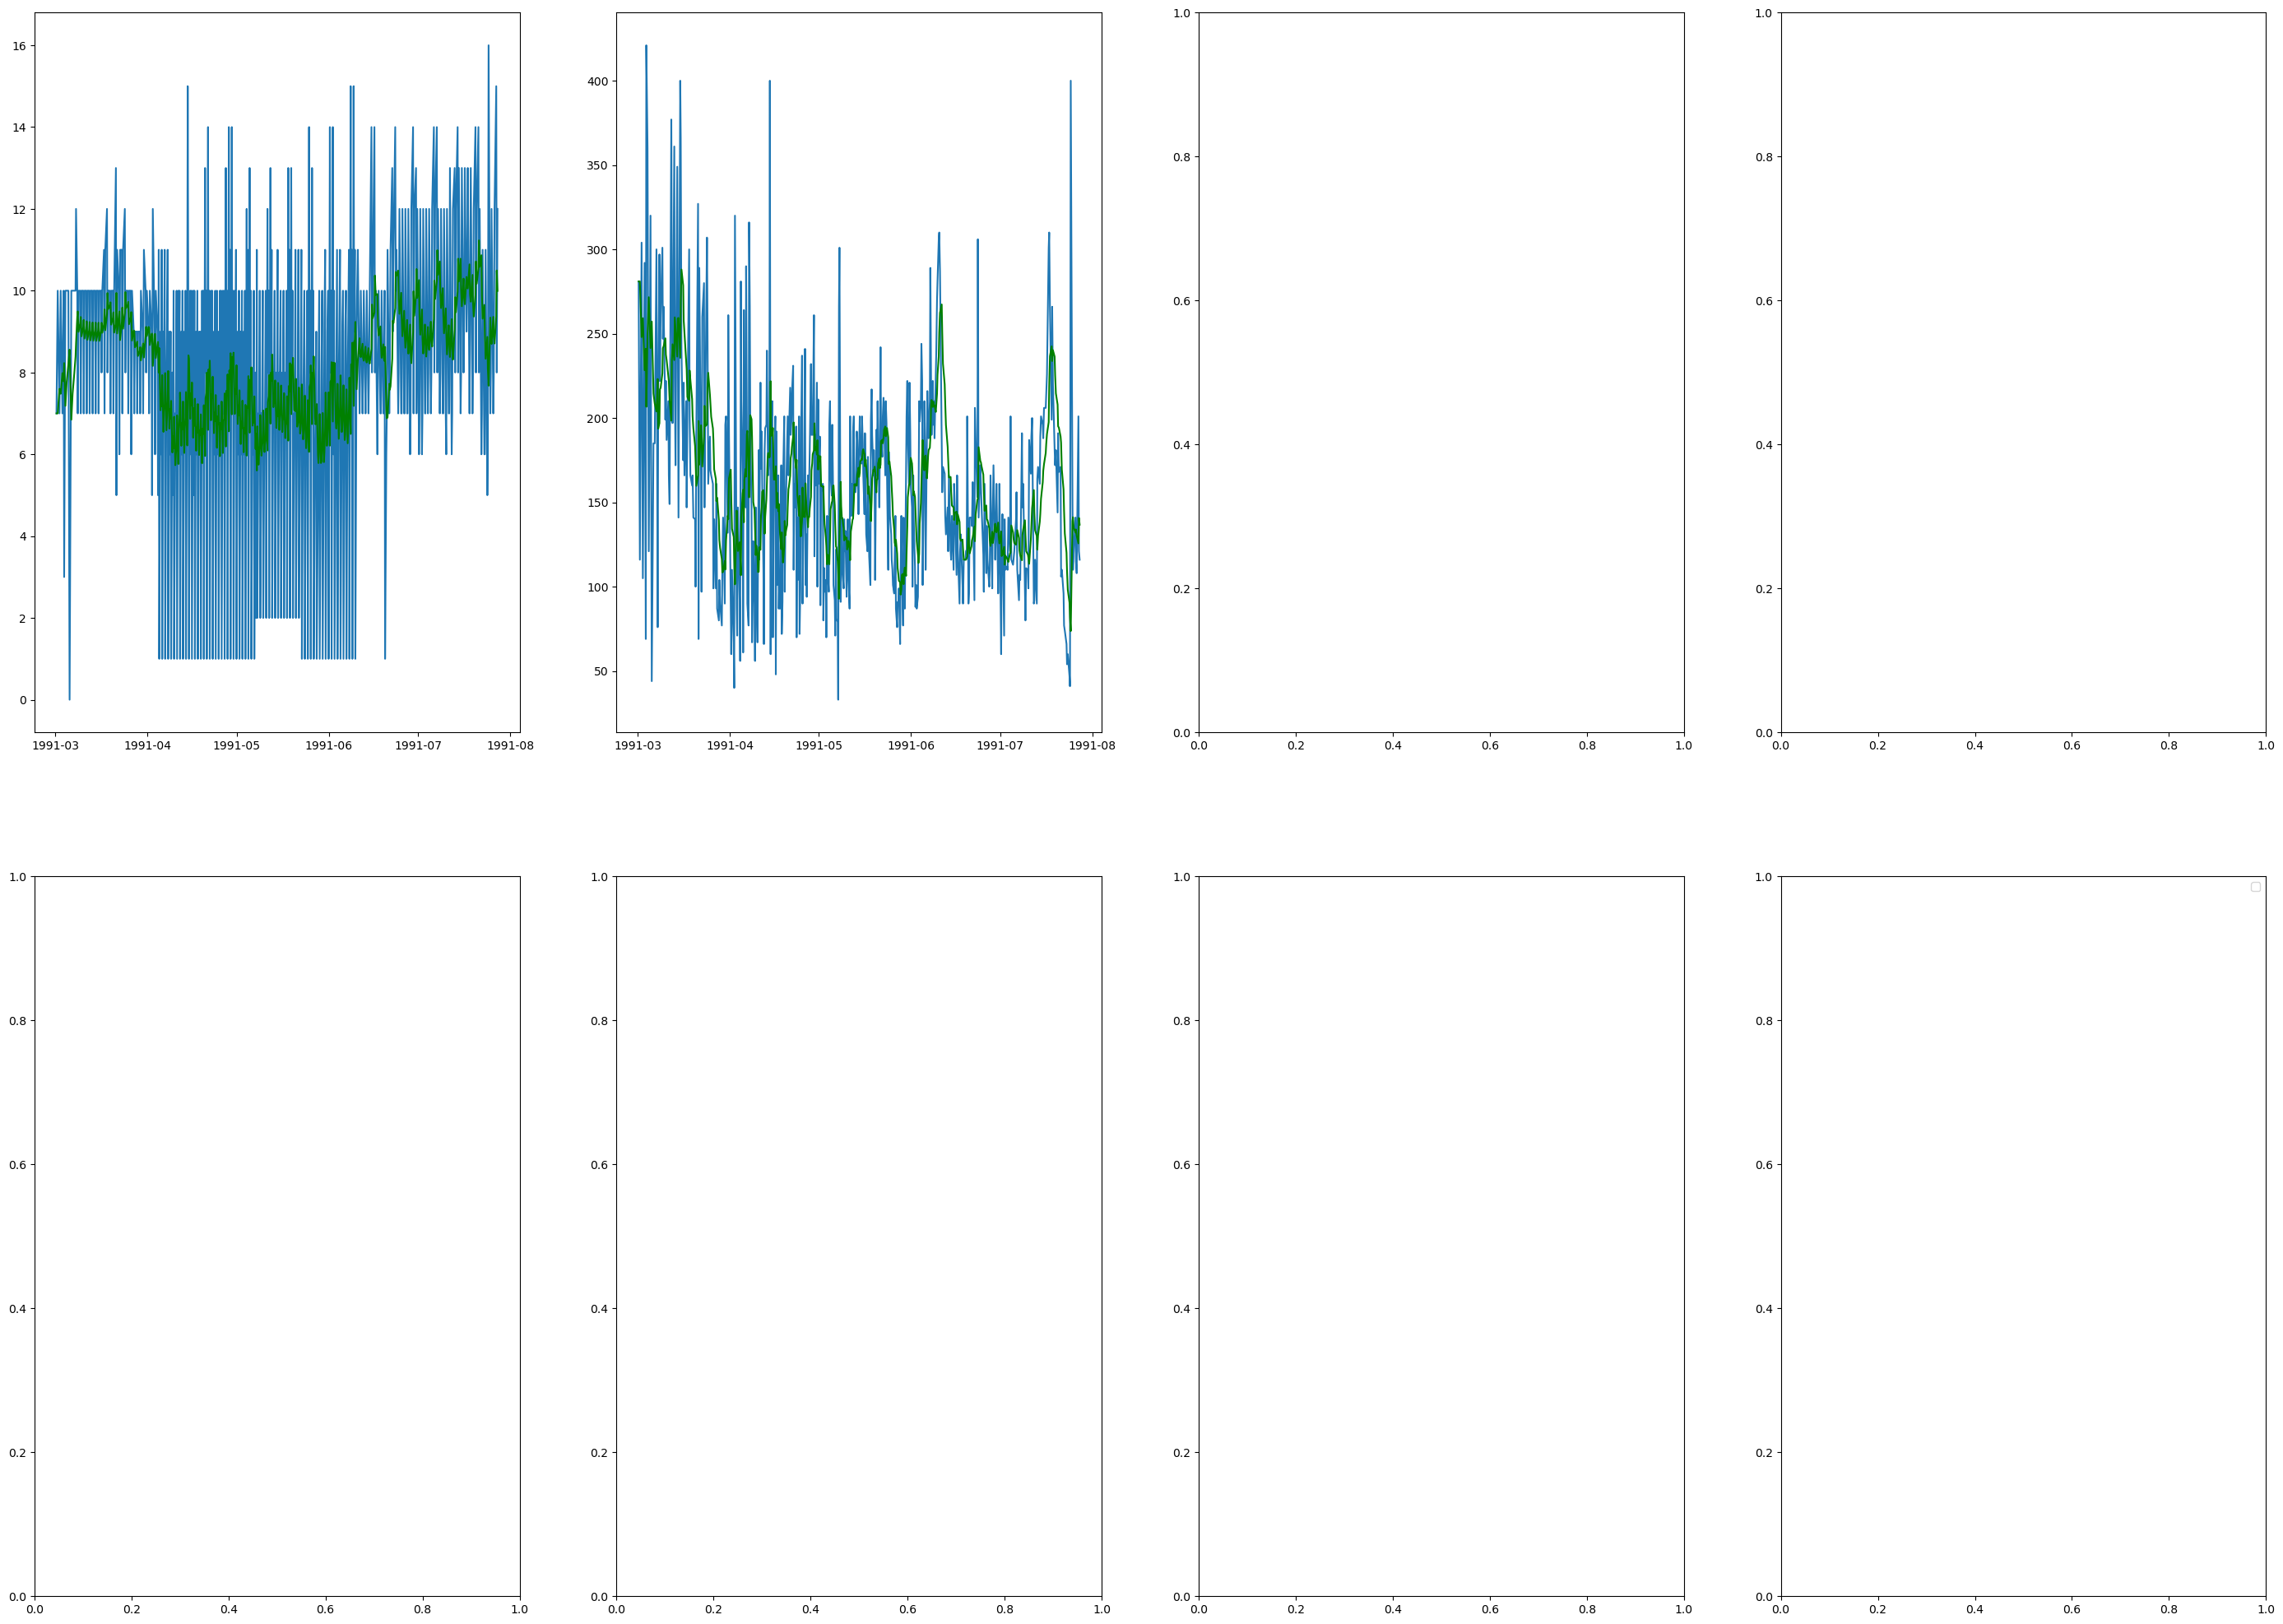

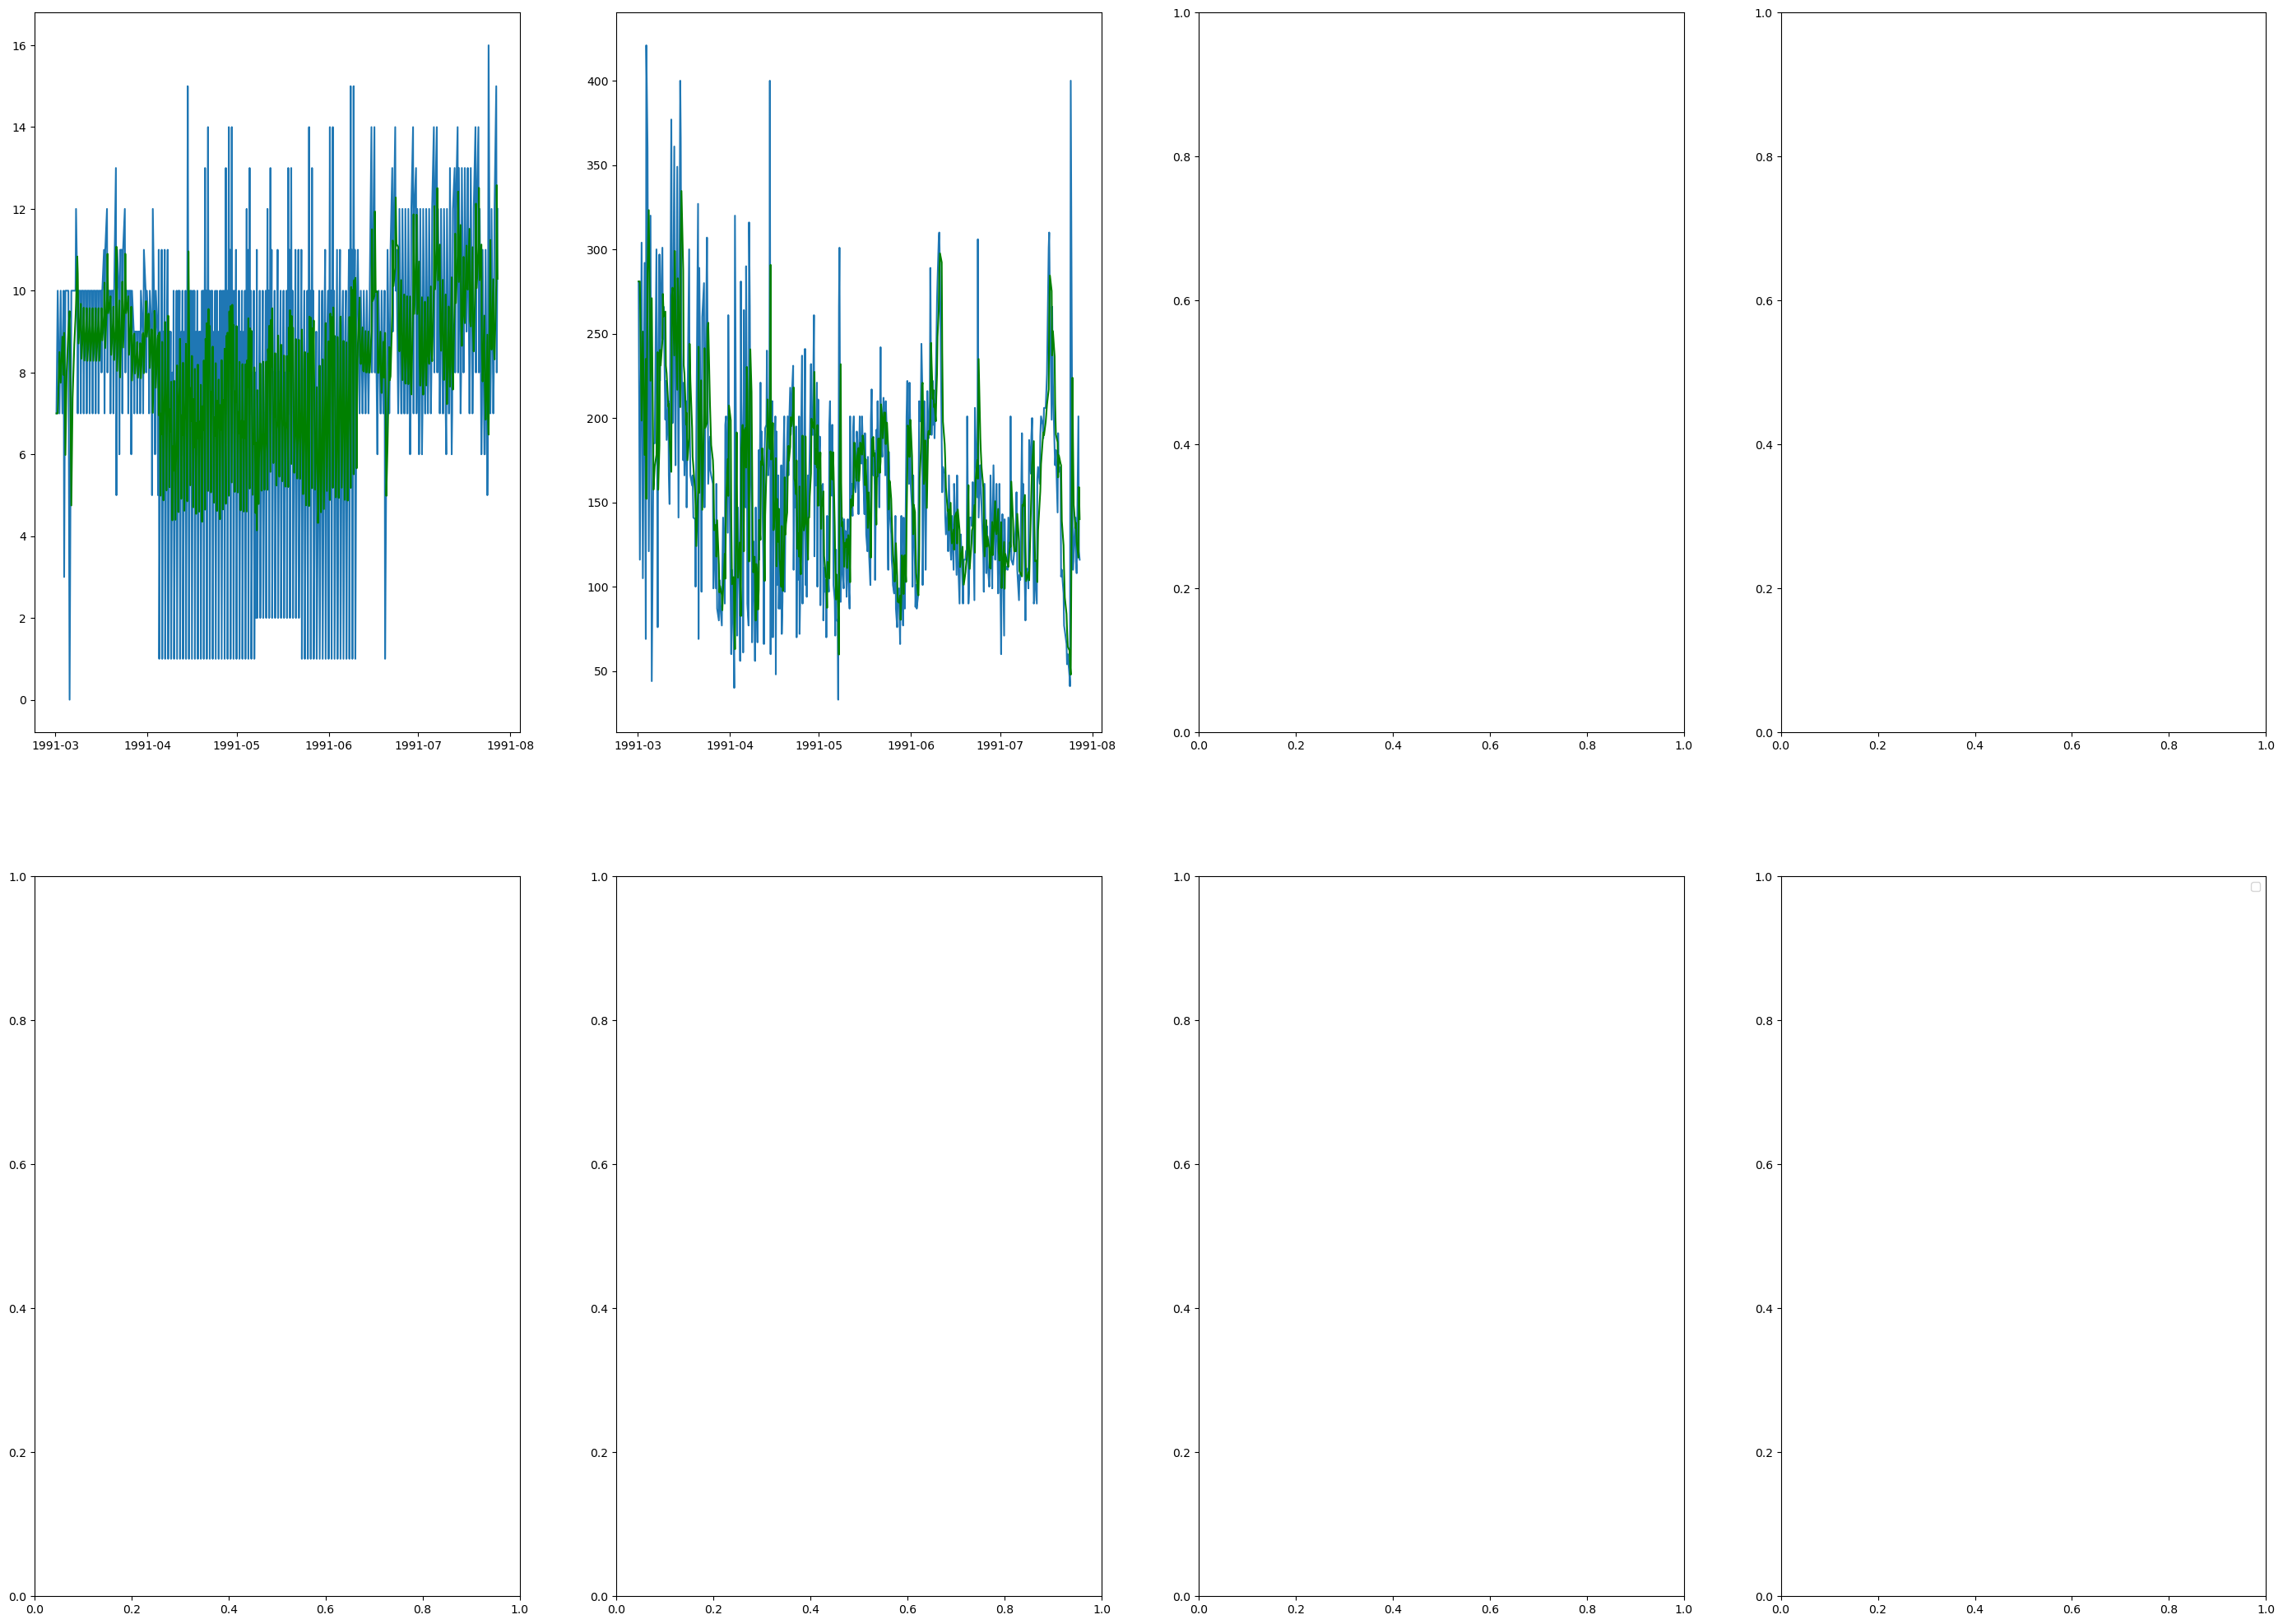

In [59]:
data_smooth_frac001 = smooth_sg1(daily_data, 0.01, 3, 'drought_forecasting_smoothing_frac001_p3',(2, 2))
data_smooth_frac005 = smooth_sg1(daily_data, 0.05, 3, 'drought_forecasting_smoothing_frac005_p3',(2, 2))
data_smooth_frac01 = smooth_sg1(daily_data, 0.1, 3, 'drought_forecasting_smoothing_frac01_p3',(2, 2))

data_smooth_ses_01 = ses(daily_data, 0.1, 'drought_forecasting_smoothing_ses_01', (2,4))
data_smooth_ses_02 = ses(daily_data, 0.2, 'drought_forecasting_smoothing_ses_02', (2,4))
data_smooth_ses_05 = ses(daily_data, 0.5, 'drought_forecasting_smoothing_ses_05', (2,4))

pers_res = pd.DataFrame(columns=['col', 'rmse_sg_0', 'rmse_sg_1', 'rmse_sg_2', 'rmse_ses_0', 'rmse_ses_1', 'rmse_ses_2'])

for col in range(len(daily_data.columns)):

    X_train_0, X_test_0, Y_train_0, Y_test_0 = temporal_data_split_forPersistence(data_smooth_frac001[col])
    X_train_1, X_test_1, Y_train_1, Y_test_1 = temporal_data_split_forPersistence(data_smooth_frac005[col])
    X_train_2, X_test_2, Y_train_2, Y_test_2 = temporal_data_split_forPersistence(data_smooth_frac01[col])

    X_train_3, X_test_3, Y_train_3, Y_test_3 = temporal_data_split_forPersistence(data_smooth_ses_01[col])
    X_train_4, X_test_4, Y_train_4, Y_test_4 = temporal_data_split_forPersistence(data_smooth_ses_02[col])
    X_train_5, X_test_5, Y_train_5, Y_test_5 = temporal_data_split_forPersistence(data_smooth_ses_05[col])


    res_ps_0, rmse_ps_0 = persistence_model(X_test_0, Y_test_0)
    res_ps_1, rmse_ps_1 = persistence_model(X_test_1, Y_test_1)
    res_ps_2, rmse_ps_2 = persistence_model(X_test_2, Y_test_2)

    res_ps_3, rmse_ps_3 = persistence_model(X_test_3, Y_test_3)
    res_ps_4, rmse_ps_4 = persistence_model(X_test_4, Y_test_4)
    res_ps_5, rmse_ps_5 = persistence_model(X_test_5, Y_test_5)


    pers_res.loc[col] = [col, rmse_ps_0, rmse_ps_1, rmse_ps_2, rmse_ps_3, rmse_ps_4, rmse_ps_5]

In [60]:
pers_res

,col,rmse_sg_0,rmse_sg_1,rmse_sg_2,rmse_ses_0,rmse_ses_1,rmse_ses_2
0,0.0,1.430447,0.307703,0.127845,0.290656,0.603121,1.705117
1,1.0,29.627184,6.526236,3.471685,5.411697,10.343990,26.072420


In [61]:
daily_data.columns

Index(['Insulin', 'Glucose'], dtype='object')

In [62]:
# choice: simple exponential smoothing with level = 0.1
data_pos_smoothing = pd.DataFrame(data_smooth_ses_01)
data_pos_smoothing = data_pos_smoothing.transpose()
data_pos_smoothing = data_pos_smoothing.rename(columns = {0:"Insulin", 1:"Glucose"})
data_pos_smoothing

,Insulin,Glucose
Date,,
1991-03-01 08:00:00,7.000000,281.000000
1991-03-01 18:00:00,7.000000,281.000000
1991-03-02 08:00:00,7.300000,264.500000
1991-03-02 18:00:00,7.270000,268.450000
1991-03-03 08:00:00,7.543000,252.105000
...,...,...
1991-07-26 12:00:00,9.074922,136.187182
1991-07-26 18:00:00,8.967430,134.068464
1991-07-27 08:00:00,9.270687,131.461617


In [63]:
# differenciation

# one differenciation
data_one_diff = data_pos_smoothing.diff(axis = 0, periods = 1)
# two differenciation
data_two_diff = data_pos_smoothing.diff(axis = 0, periods = 1)
data_two_diff = data_two_diff.diff(axis = 0, periods = 1)

In [64]:

data_one_diff = data_one_diff.iloc[1:,:]
data_two_diff = data_two_diff.iloc[2:,:]

In [65]:
res_diff = pd.DataFrame(columns=['col', 'rmse_oneDiff', 'rmse_twoDiff', 'rmse_noDiff'])

for col in range(len(data_one_diff.columns)):

    X_train_oneDiff, X_test_oneDiff, Y_train_oneDiff, Y_test_oneDiff = temporal_data_split_forPersistence(data_one_diff.iloc[:,col])
    X_train_twoDiff, X_test_twoDiff, Y_train_twoDiff, Y_test_twoDiff = temporal_data_split_forPersistence(data_two_diff.iloc[:,col])
    X_train_noDiff, X_test_noDiff, Y_train_noDiff, Y_test_noDiff = temporal_data_split_forPersistence(data_pos_smoothing.iloc[:,col])

    res_oneDiff, rmse_oneDiff = persistence_model(X_test_oneDiff, Y_test_oneDiff)
    res_twoDiff, rmse_twoDiff = persistence_model(X_test_twoDiff, Y_test_twoDiff)
    res_noDiff, rmse_noDiff = persistence_model(X_test_noDiff, Y_test_noDiff)
    
    res_diff.loc[col] = [col, rmse_oneDiff, rmse_twoDiff, rmse_noDiff]

X_train_noDiff, X_test_noDiff, Y_train_noDiff, Y_test_noDiff = temporal_data_split_forPersistence(data_one_diff.iloc[:,col])

In [66]:
res_diff

,col,rmse_oneDiff,rmse_twoDiff,rmse_noDiff
0,0.0,0.458887,0.788271,0.290656
1,1.0,6.485788,11.173272,5.411697


In [67]:
# choice: don't use differenciation
data_pos_smoothing

,Insulin,Glucose
Date,,
1991-03-01 08:00:00,7.000000,281.000000
1991-03-01 18:00:00,7.000000,281.000000
1991-03-02 08:00:00,7.300000,264.500000
1991-03-02 18:00:00,7.270000,268.450000
1991-03-03 08:00:00,7.543000,252.105000
...,...,...
1991-07-26 12:00:00,9.074922,136.187182
1991-07-26 18:00:00,8.967430,134.068464
1991-07-27 08:00:00,9.270687,131.461617


In [69]:
data_pos_smoothing.to_csv("intermediate_data/data_drought_forecasting_prepared.csv", encoding='utf-8', columns=data_pos_smoothing.columns, index=True)